[Taichi] Starting on arch=cuda
0.007500000000000284 0.00749999999999984
-0.010624999999999885 0.020625000000000004
0.28125
(0.5, 1.625) (1.0, 1.125)


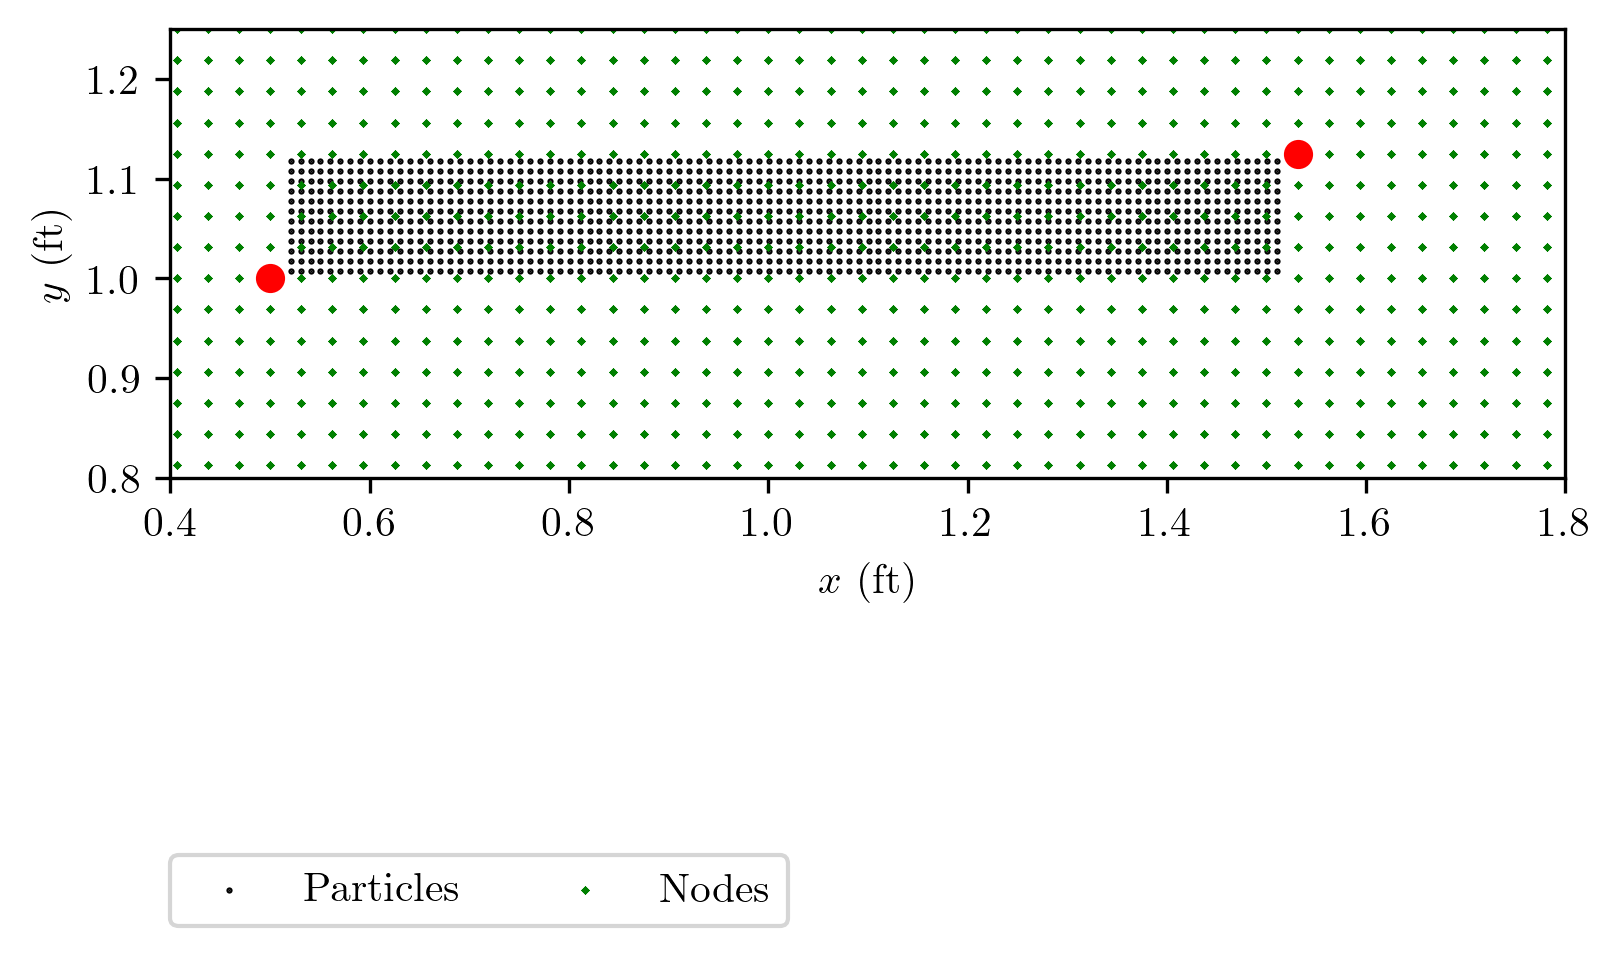

In [74]:
import taichi as ti
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

ti.reset()
real = ti.f32
ti.init(arch=ti.cuda, default_fp=real, device_memory_GB=12)
# init parameters
size = 2.000 # 2 m
span = 1.000 # 4.4 m
depth = 0.120 # 0.4 m
dim = 2
factor = 1/100
Nx = int(span / factor)
Ny = int(depth / factor)
n_particles = int(Nx * Ny)
grid_factor = 4
n_grid = 16*grid_factor
dx = size / n_grid
inv_dx = 1 / dx
dt =  1 / 1000

x_p, y_p = np.zeros(n_particles), np.zeros(n_particles)
x_n, y_n = np.meshgrid(np.arange(n_grid)*dx, np.arange(n_grid)*dx)
for i in range(Nx):
    for j in range(Ny):
        x_p[j * Nx + i] = ((i)/(Nx) * 0.5 + 0.25 + 0.5 / Nx * 0.5 + 1/2 * 1/n_grid) * size
        y_p[j * Nx + i] = ((j)/(Ny) * 0.06 + 0.5 + (0.125-0.12)*(1/4) + 0.06 / Ny * 0.5) * size
n_particles = Nx * Ny

print(1.125 - y_p.max(), y_p.min()-1)
print(1.5 - x_p.max(), x_p.min()-0.5)
print(dx*9)


matplotlib.rc('text', usetex = True)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300
font = {'size'   : 20}
def gray(level):
    return (level, level, level)

plt.figure()
s=1
plt.scatter(x_p, y_p, color=gray(0), marker = '.',s=s, label='Particles')
# plt.plot(np.array([0.2, 0.84, 0.84, 0.2, 0.2])*size/12, np.array([0.36, 0.36, 0.4, 0.4, 0.36])*size/12, label='Beam boundary')
plt.scatter(x_n, y_n, color='g', marker='x', s=s, label='Nodes')
plt.scatter((4*dx*grid_factor,(13*grid_factor-3)*dx),(8*dx*grid_factor,9*dx*grid_factor), color='r')
# plt.scatter(np.array([5, 7, 9, 11, 13, 15, 17, 19, 21])*dx*4, np.zeros(9)+dx*7*4, color='b', label='Accelerometer')
# plt.scatter(np.array([6, 8, 10, 12, 14, 16, 18, 20])*dx*4, np.zeros(8)+dx*7*4, color='orange', label='Impact')
print((4*dx*4,13*dx*4),(8*dx*4,9*dx*4))
plt.legend(loc=(0, -1), ncol=2)
# plt.title('Material Points Used Per Observability Case')
plt.xlabel('$x$ (ft)')
plt.ylabel('$y$ (ft)')
plt.ylim((0.8, 1.25))
plt.xlim((0.4, 1.8))
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
# plt.savefig('D:/Research/Masonry-Rail/3 Damage ID/test.png', dpi=300, bbox_inches = "tight")
plt.show()


0.02350770030170679


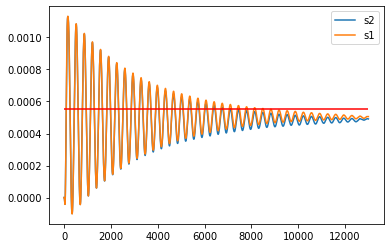

In [40]:
import einops
size = 2.000 # 2 m
span = 1.000 # 4.4 m
depth = 0.120 # 0.4 m
dim = 2
factor = 1/100
Nx = int(span / factor)
Ny = int(depth / factor)
n_particles = int(Nx * Ny)
grid_factor = 1
n_grid = 16*grid_factor

strain = np.load(f"s.npy")
strain1 = np.load(f"s1.npy")

def process(x, Nx, Ny):
    reshaped = einops.rearrange(x, 't (x y) -> t x y', x=Ny, y=Nx)
    avg = reshaped[:, 0]
    return avg

s_avg= process(strain1[:,:,0,0], Nx, Ny)
s2_avg= process(strain[:,:,0,0], Nx, Ny)

strain[:, int(n_particles/2), 0, 0].shape
print(np.abs(np.average(strain1[:, :, 0, 0], axis=1)[-1] - 200*1e3/(0.12*0.12*25e9)) / (200*1e3/(0.12*0.12*25e9)))

# plt.plot(np.average(strain[:, :, 0, 0], axis=1), label='s2')
# plt.plot(np.average(strain1[:, :, 0, 0], axis=1), label='s1')
plt.plot(s2_avg[:13000,int(Nx/2)], label='s2')
plt.plot(s_avg[:13000,int(Nx/2)], label='s1')

plt.hlines(200*1e3/(0.12*0.12*25e9), 0, 13000, color='r')
plt.legend()
plt.show()

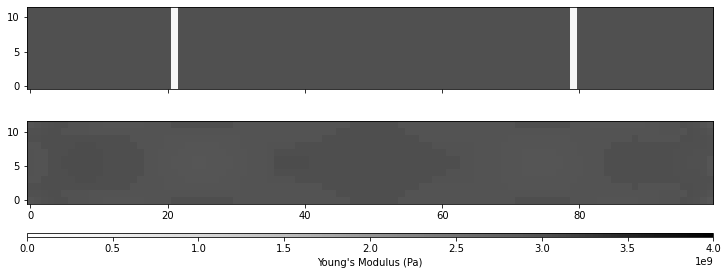

In [31]:
import einops, json
import numpy as np
import matplotlib.pyplot as plt

size = 2.000 # 2 m
span = 1.000 # 4.4 m
depth = 0.120 # 0.4 m
dim = 2
factor = 1/100
Nx = int(span / factor)
Ny = int(depth / factor)
n_particles = int(Nx * Ny)
grid_factor = 1
n_grid = 16*grid_factor

file = "E_rand.npy"
result = np.load(file, allow_pickle=True)
E = einops.rearrange(result, "(y x) -> x y", y=Ny).transpose()

fig, axs = plt.subplots(2,1, sharex=True, sharey=True, figsize=(10,4), layout='constrained')
im = axs[0].imshow(E, origin='lower', cmap='Greys', vmin=0, vmax=4e9)
filename = [
    f"r_full.json"
    ,
]
with open(filename[0]) as json_file:
    result = json.load(json_file)['E_hist']
result = np.array(result)[-1]
E = einops.rearrange(result, "(y x) -> x y", y=Ny).transpose()
axs[1].imshow(E, origin='lower', cmap='Greys', vmin=0, vmax=4e9)
fig.colorbar(im, 
            ax=axs, 
            orientation = 'horizontal', 
            label='Young\'s Modulus (Pa)', 
            aspect=200)
plt.show()

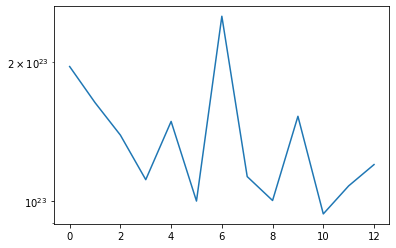

In [34]:
filename = [
    f"r_full.json",
]
with open(filename[0]) as json_file:
    result = json.load(json_file)
losses = result['losses']

plt.plot(losses[2:])
plt.yscale('log')
plt.show()

In [46]:
x_1 = np.load('x_1.npy')
print(np.mean(x_1[0], axis=0), np.mean(x_1[-1], axis=0))

x_5 = np.load('x_5.npy')
print(np.mean(x_5[0], axis=0), np.mean(x_5[-1], axis=0))

[1.0625001 1.0625095] [1.0624989 1.0625033]
[1.0625001 1.0625095] [1.0625001 1.0625011]


22
22
19
23
20


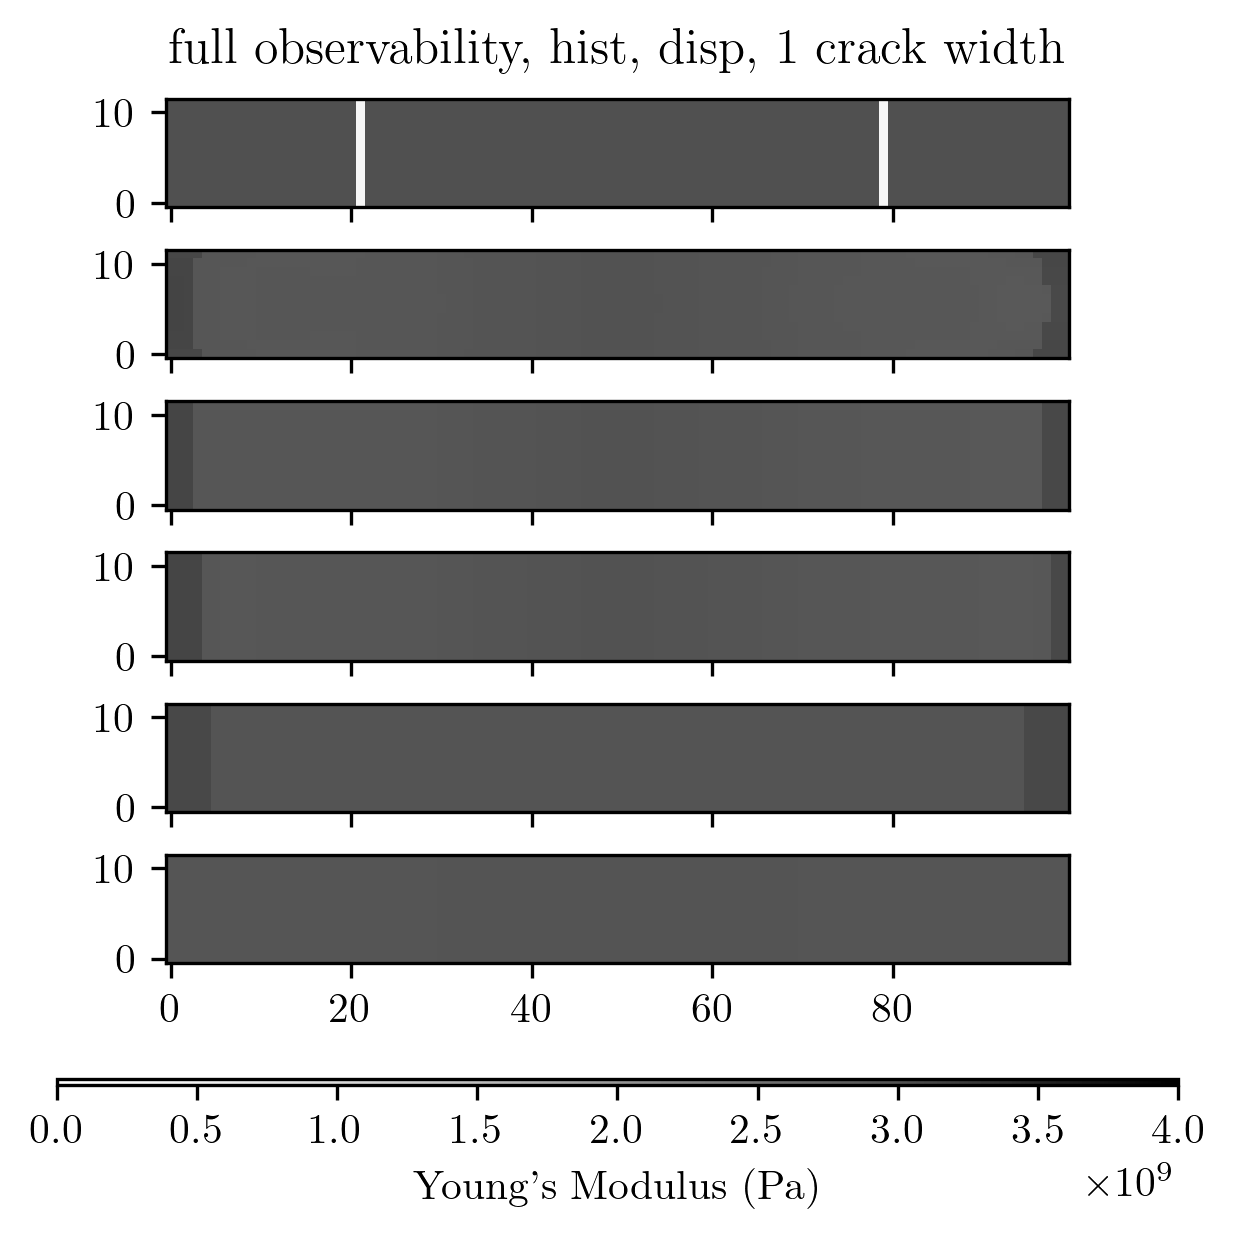

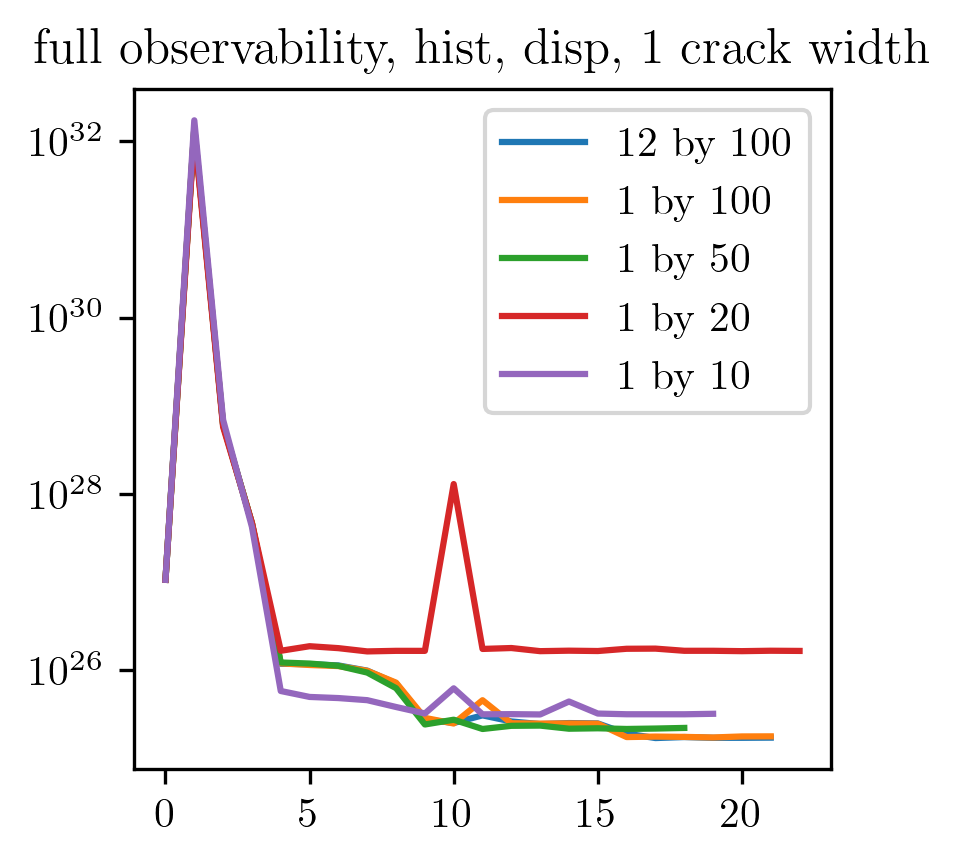

42
37
31
26
33


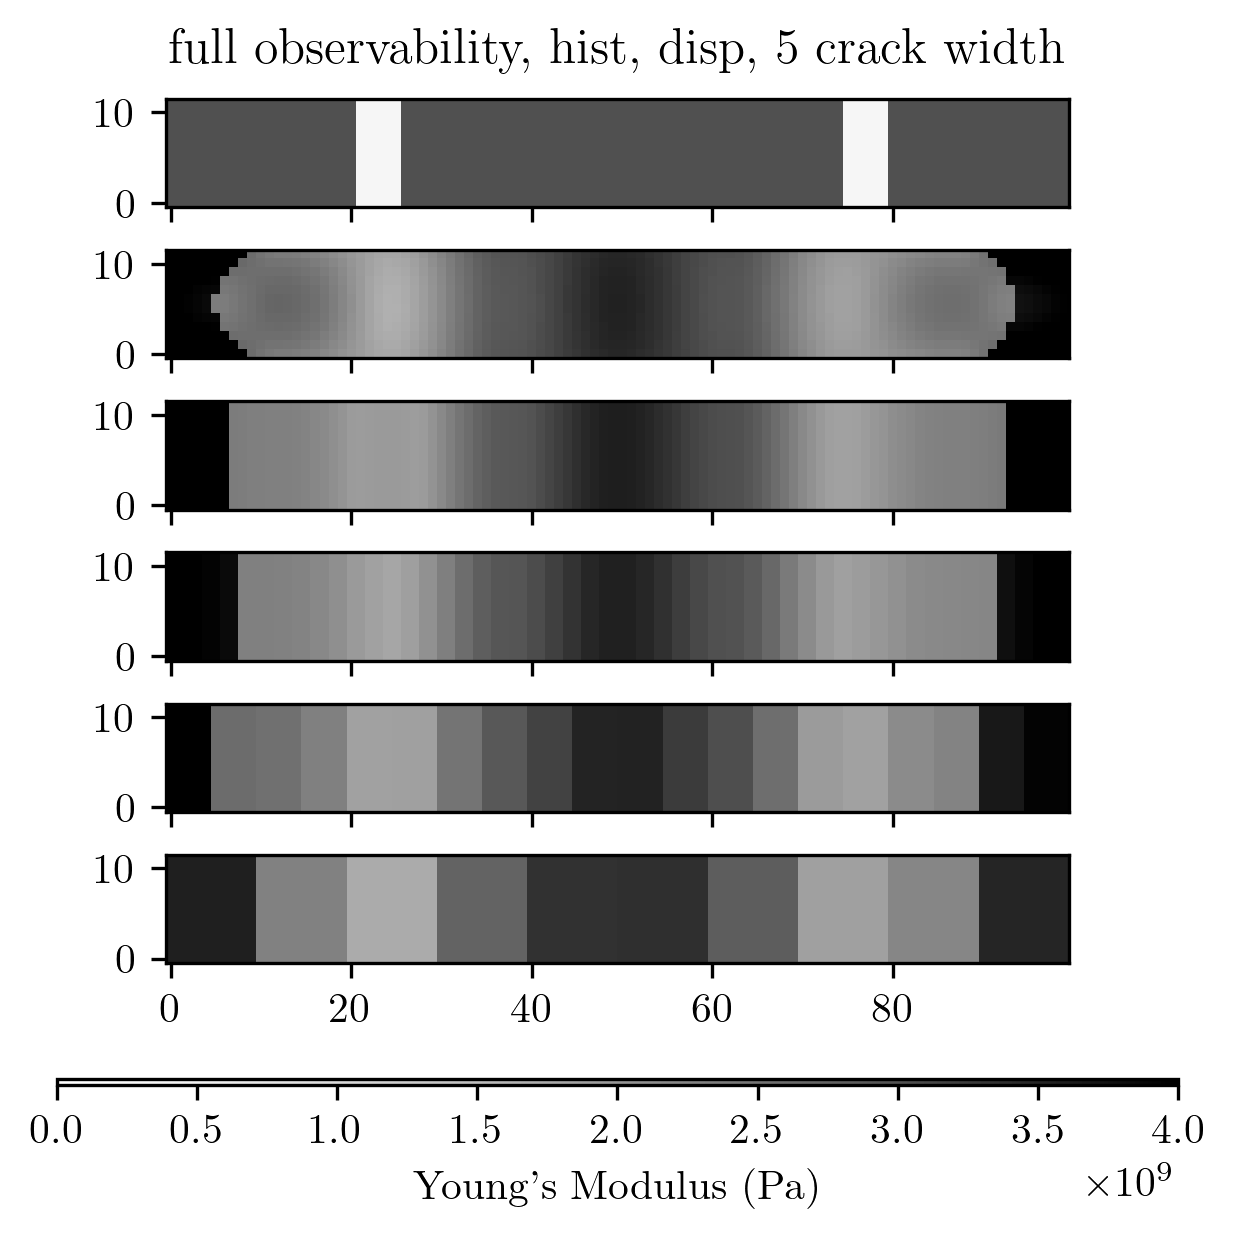

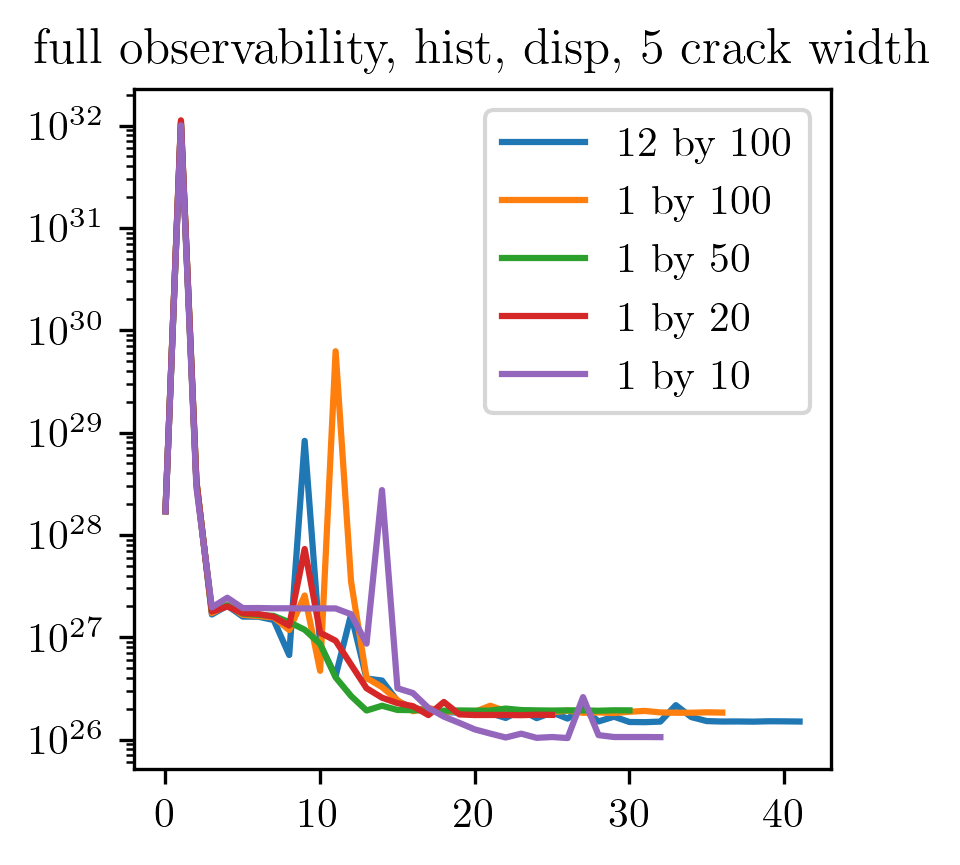

24
18
20
24
17


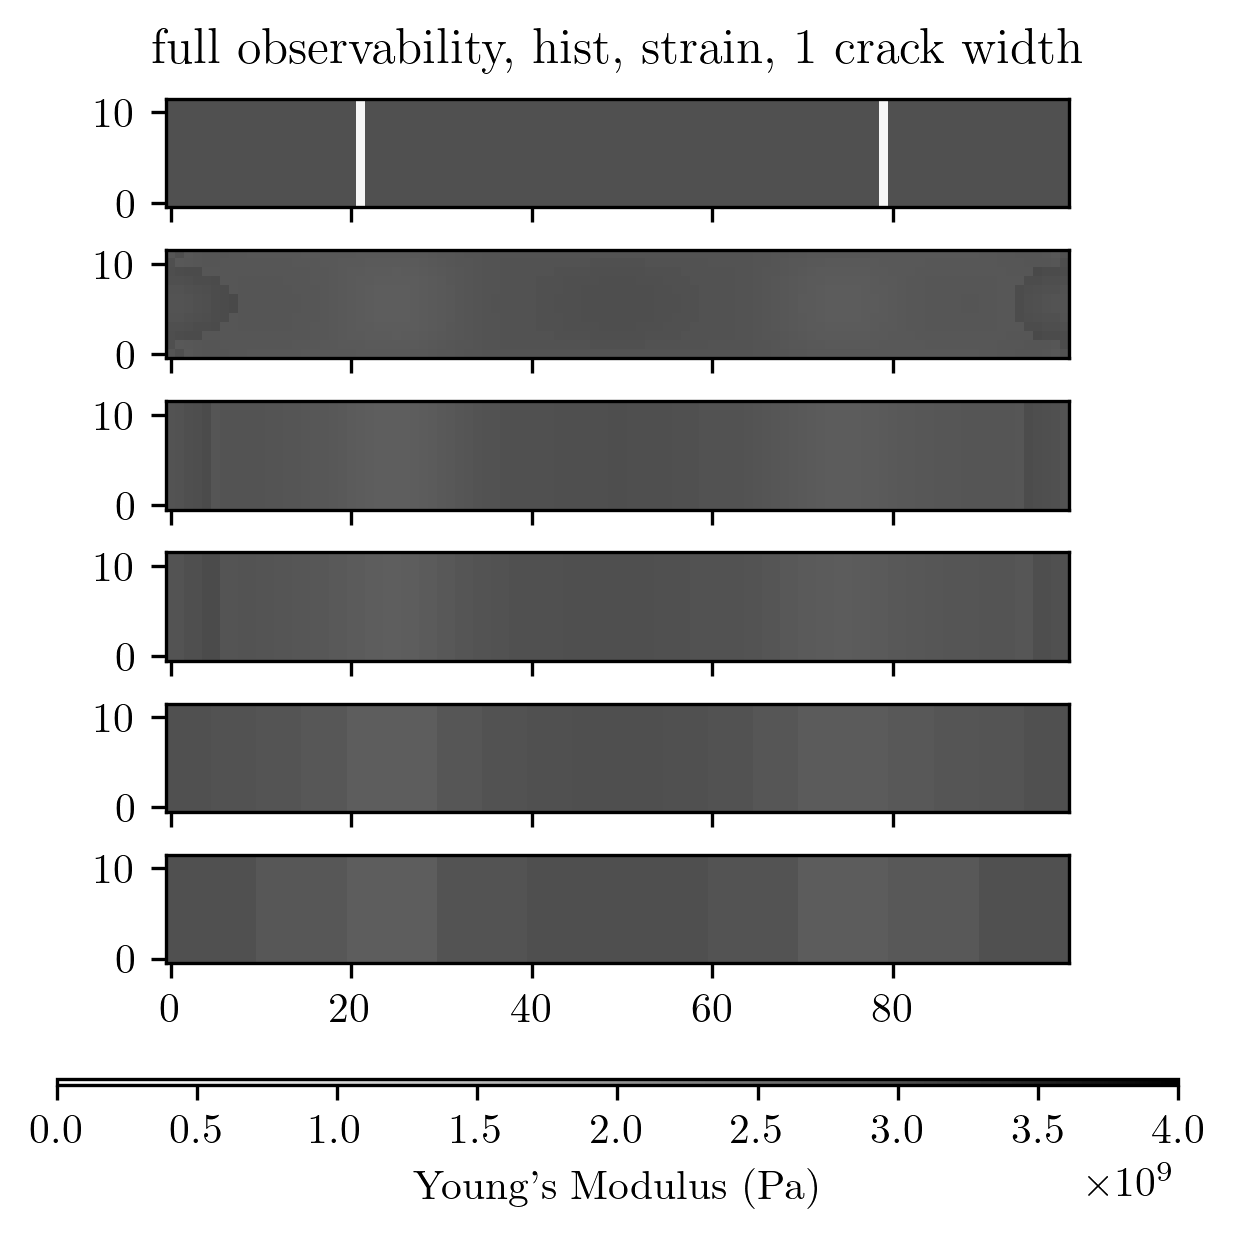

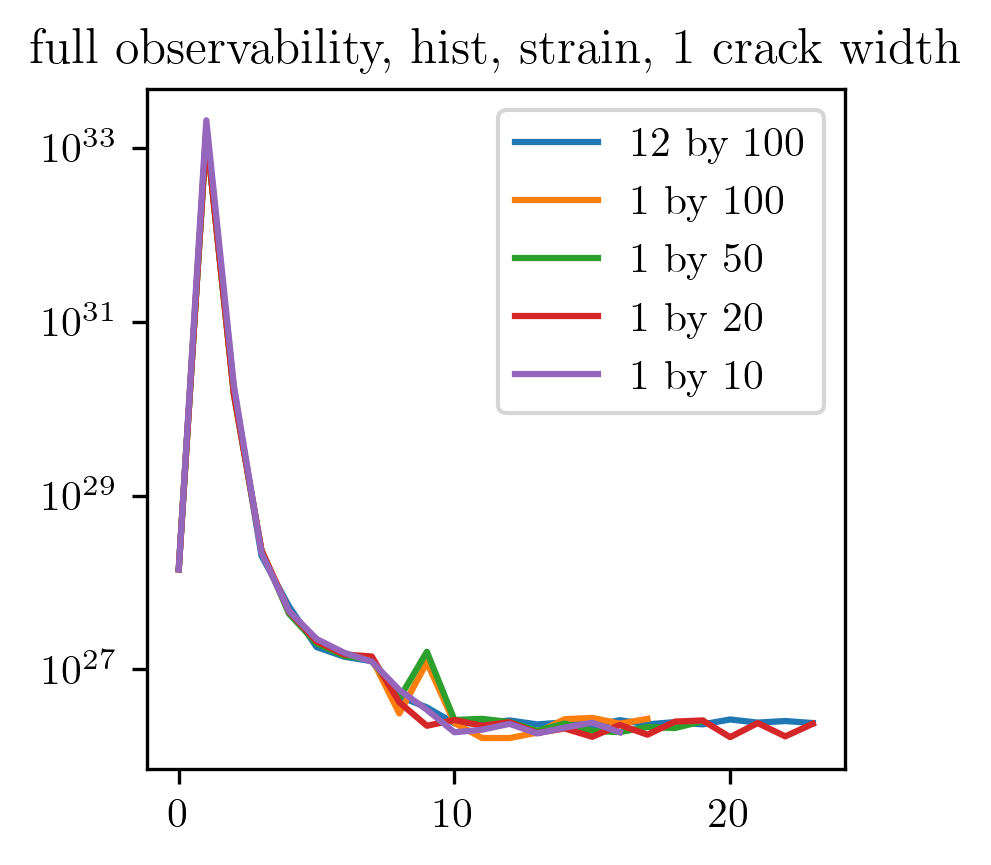

18
18
28
18
21


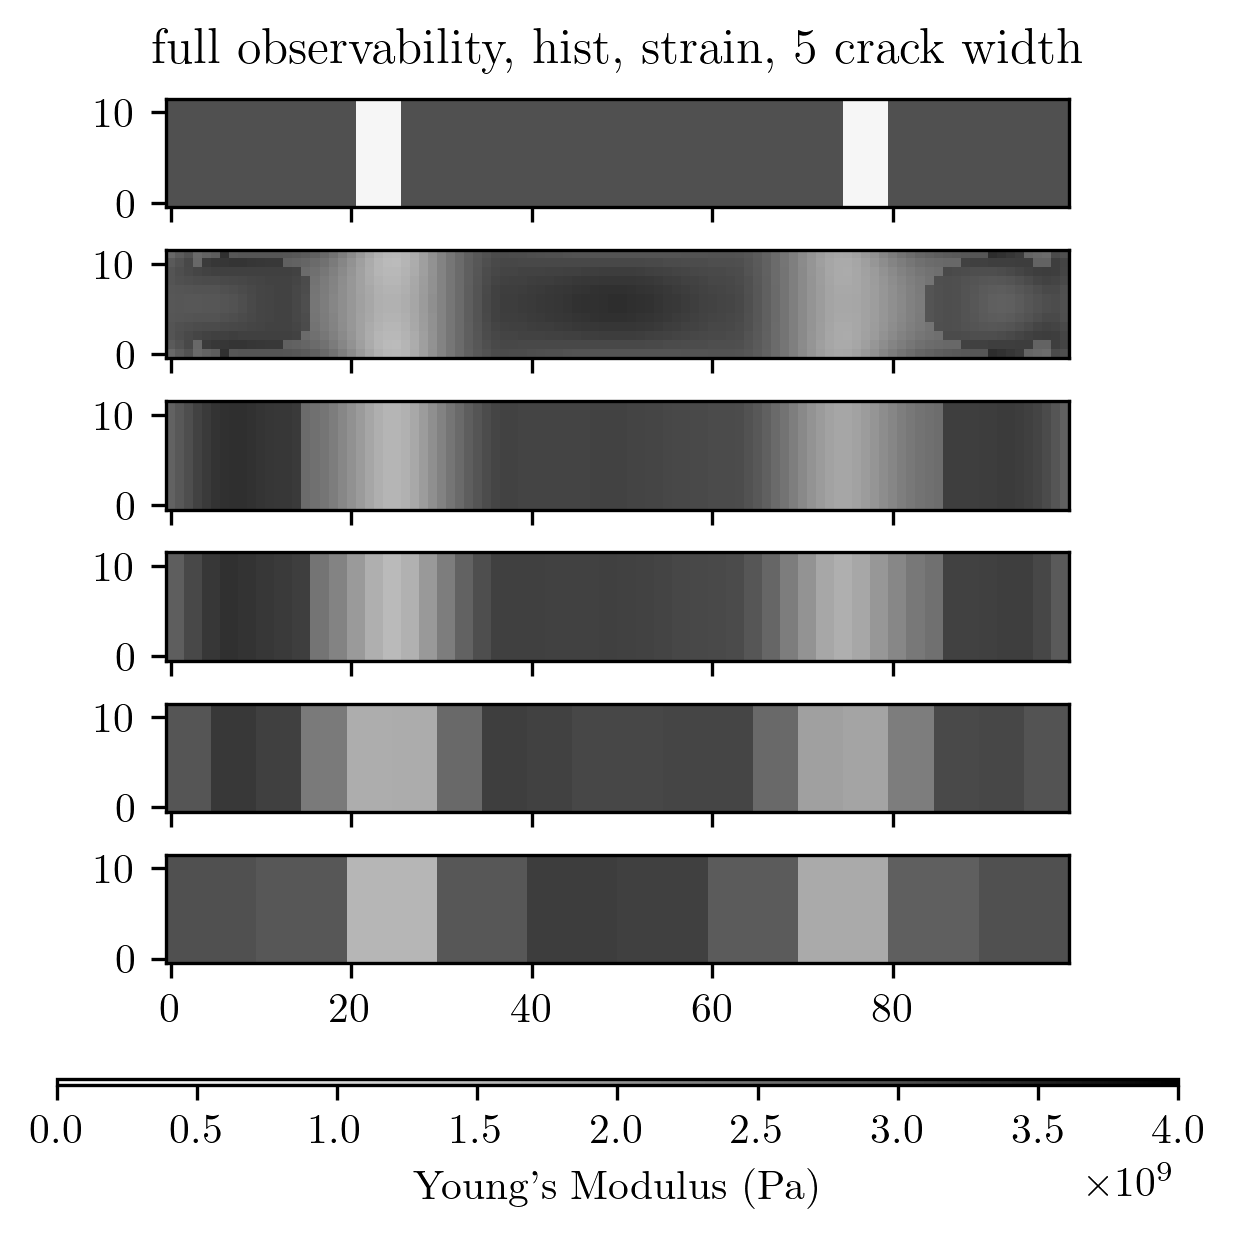

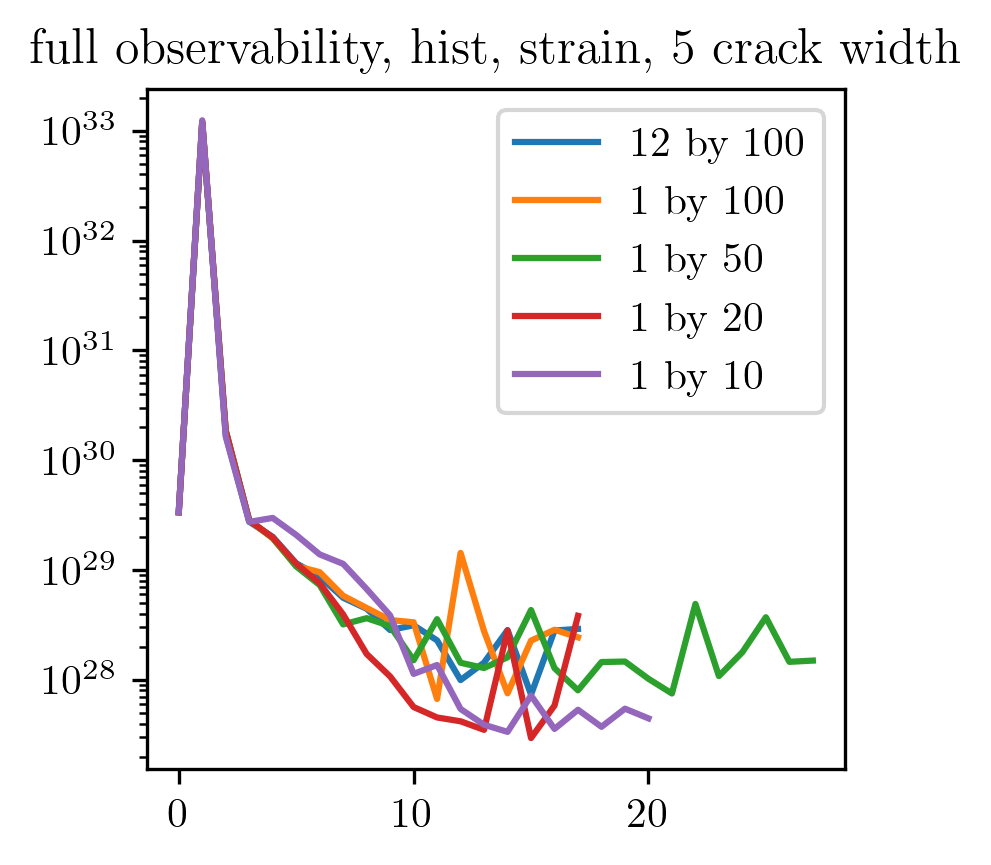

7
11
7
12
9


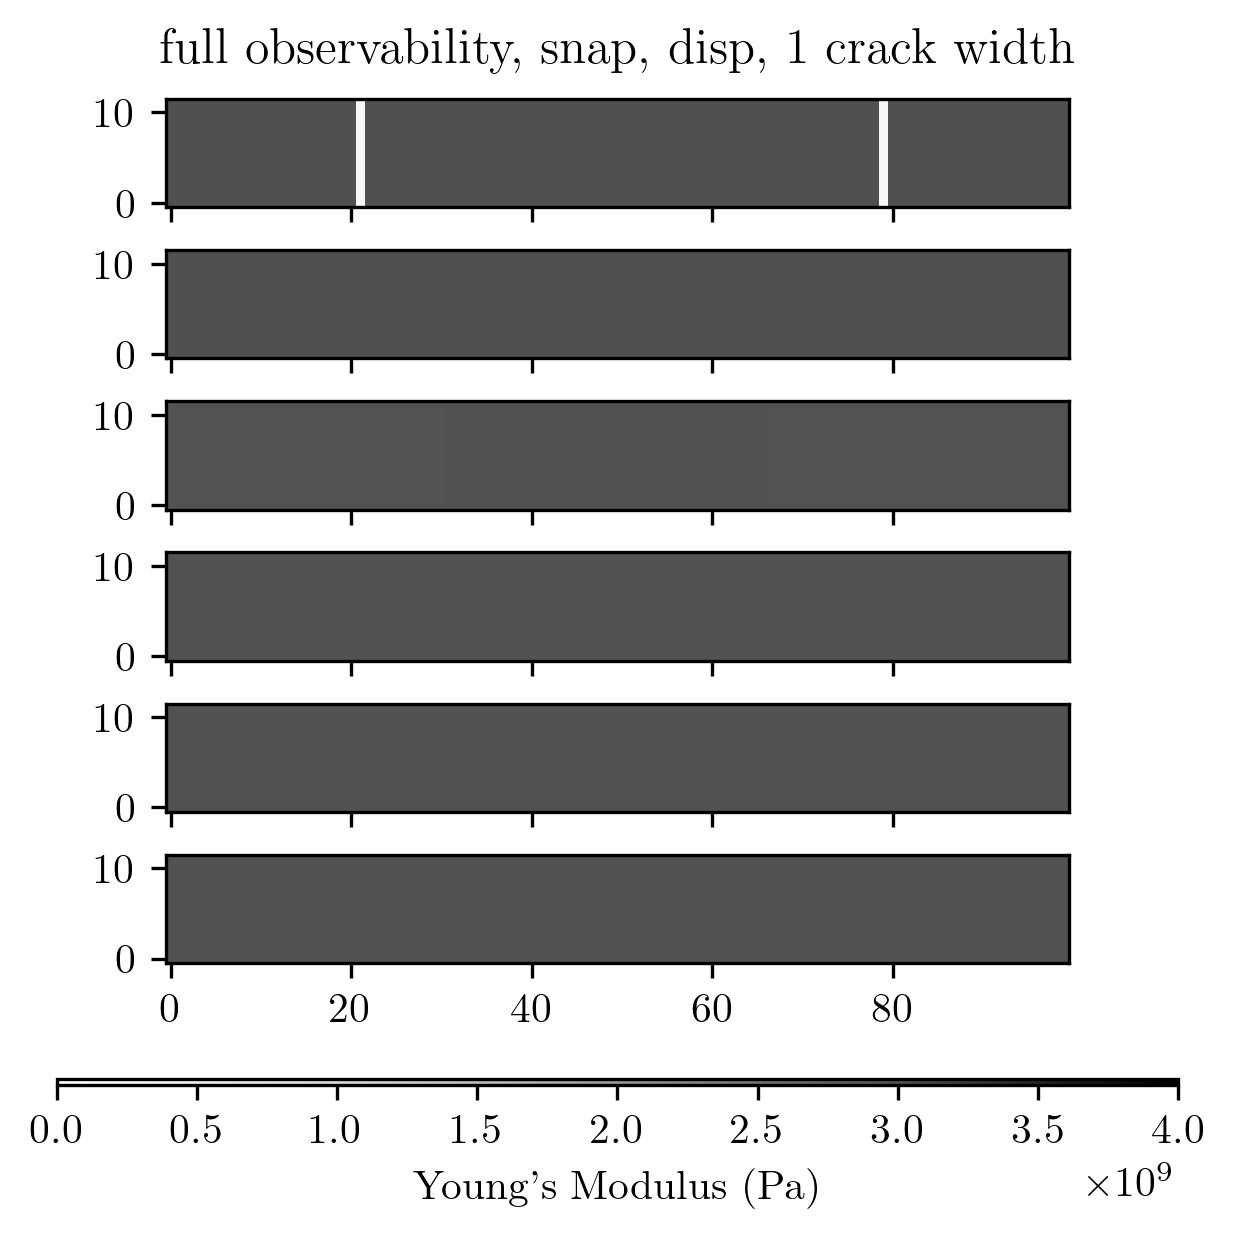

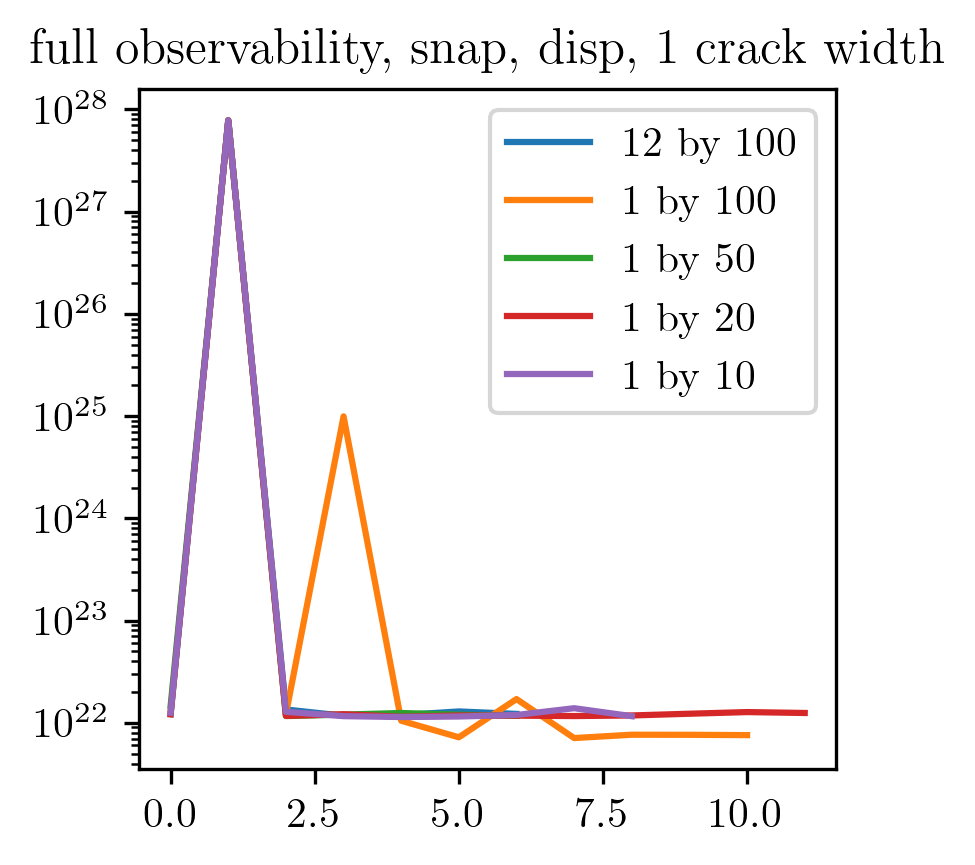

32
25
5
6
8


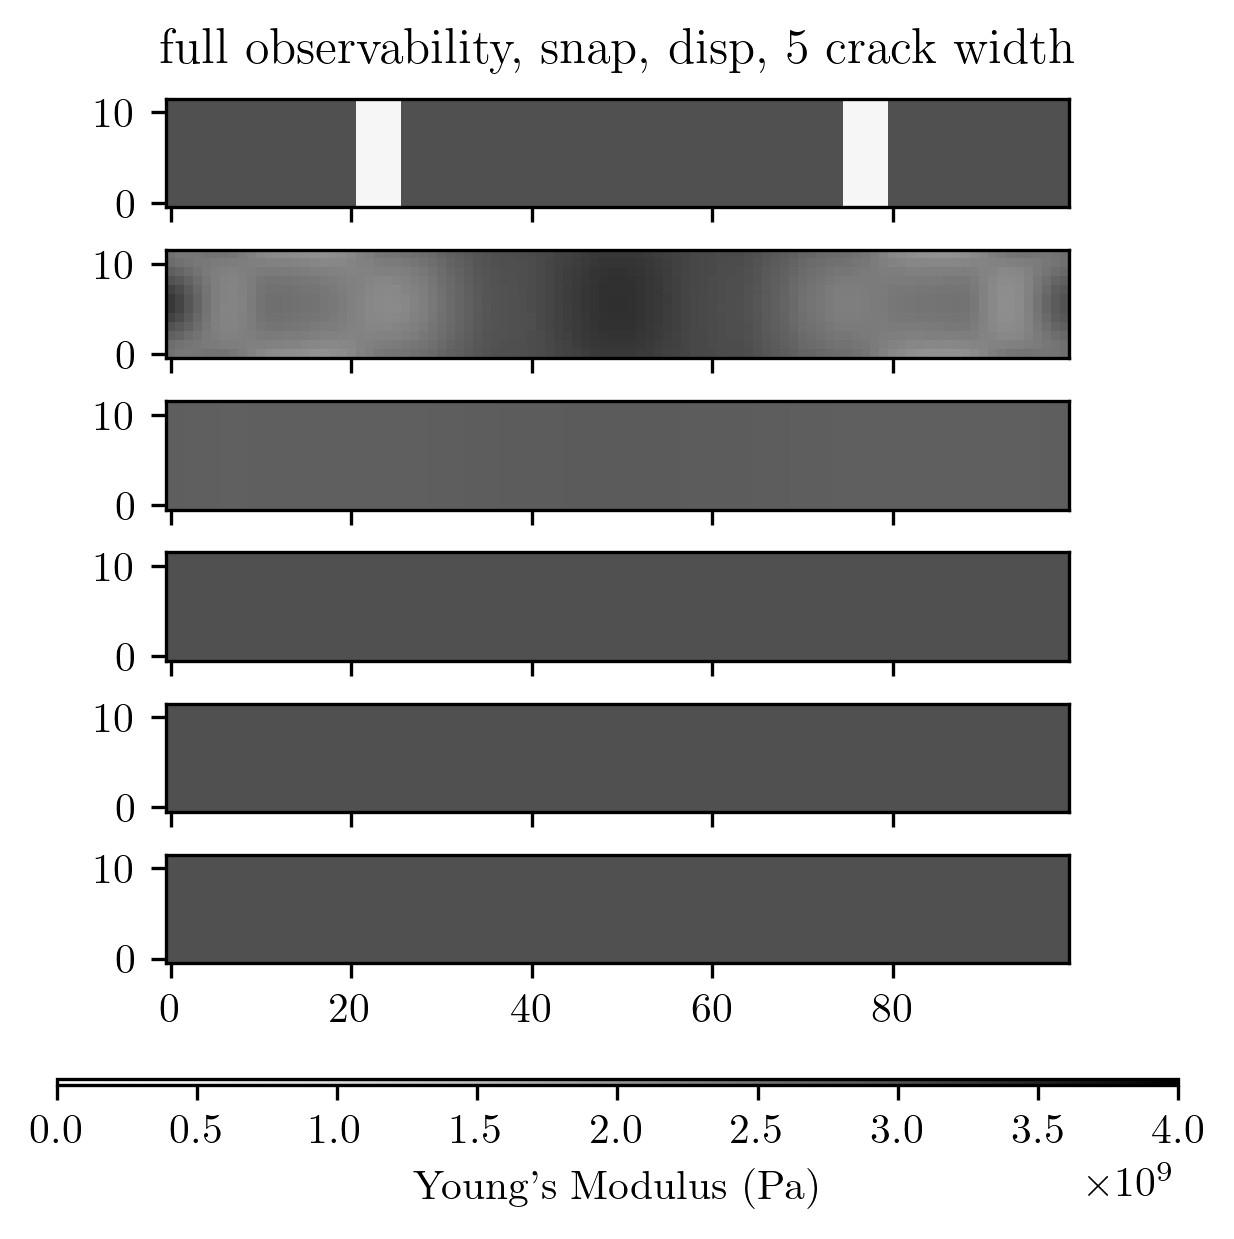

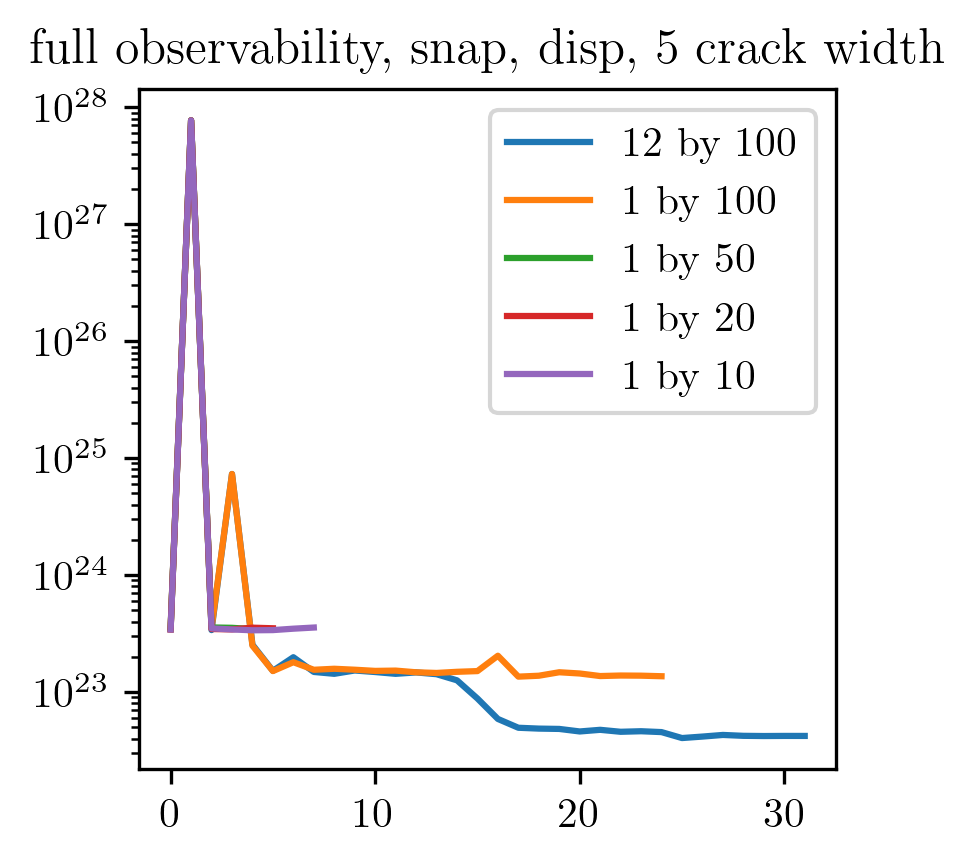

15
11
18
9
26


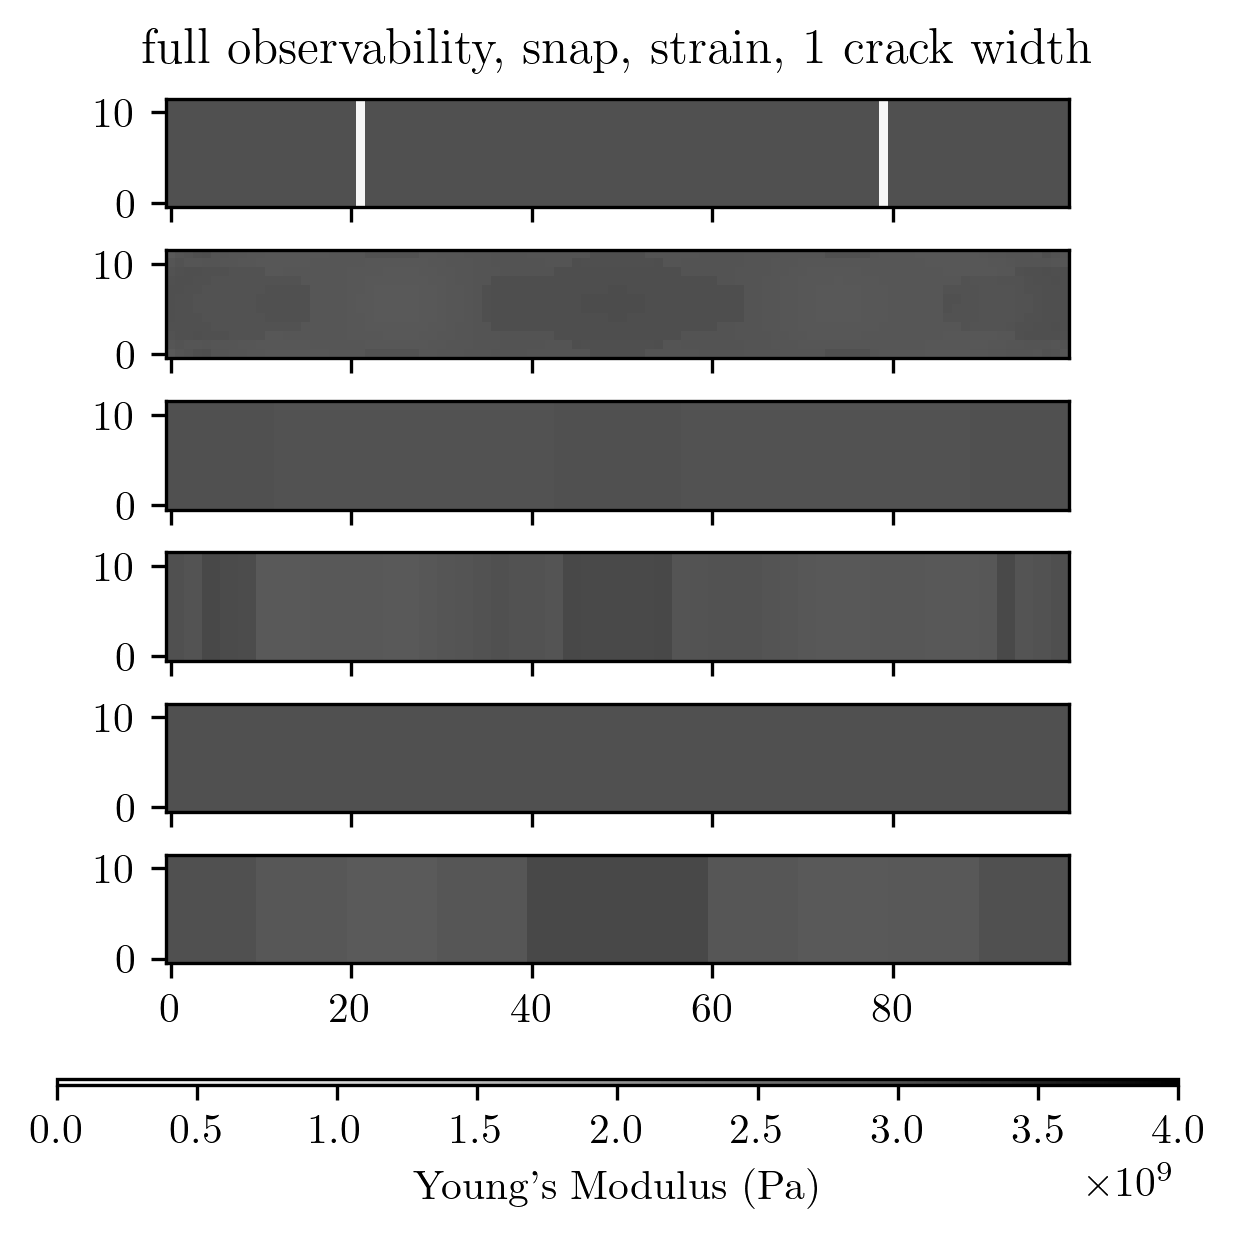

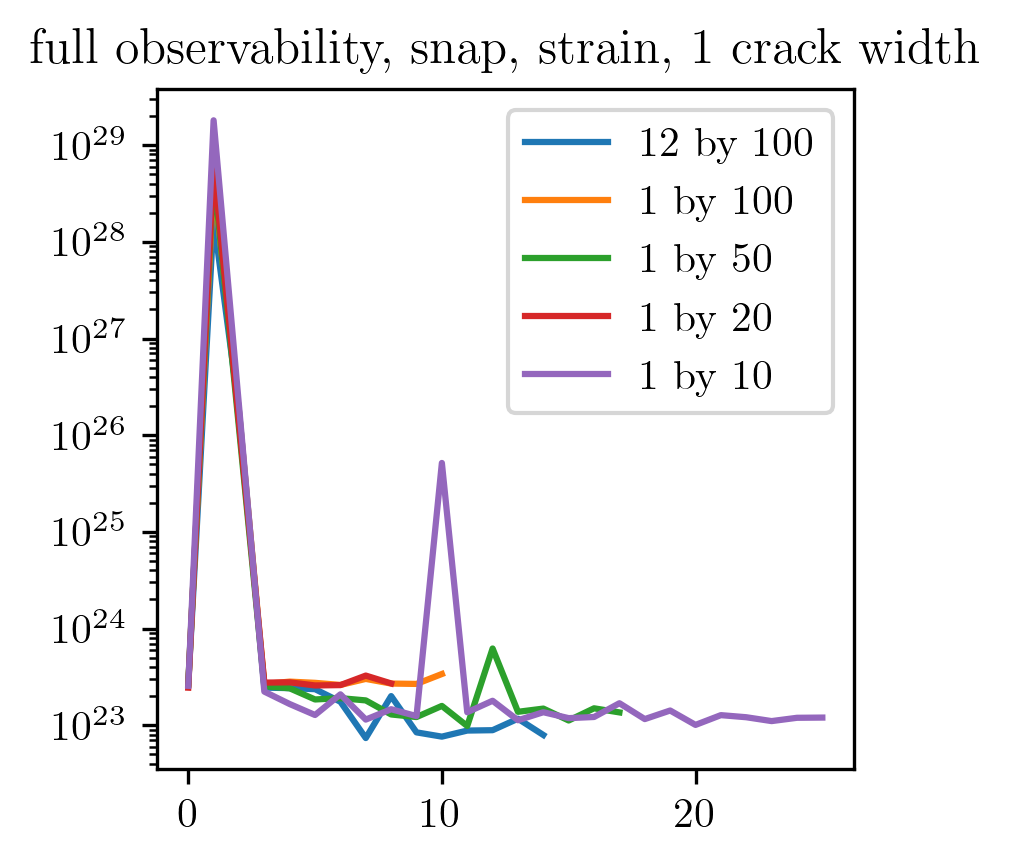

20
13
23
17
12


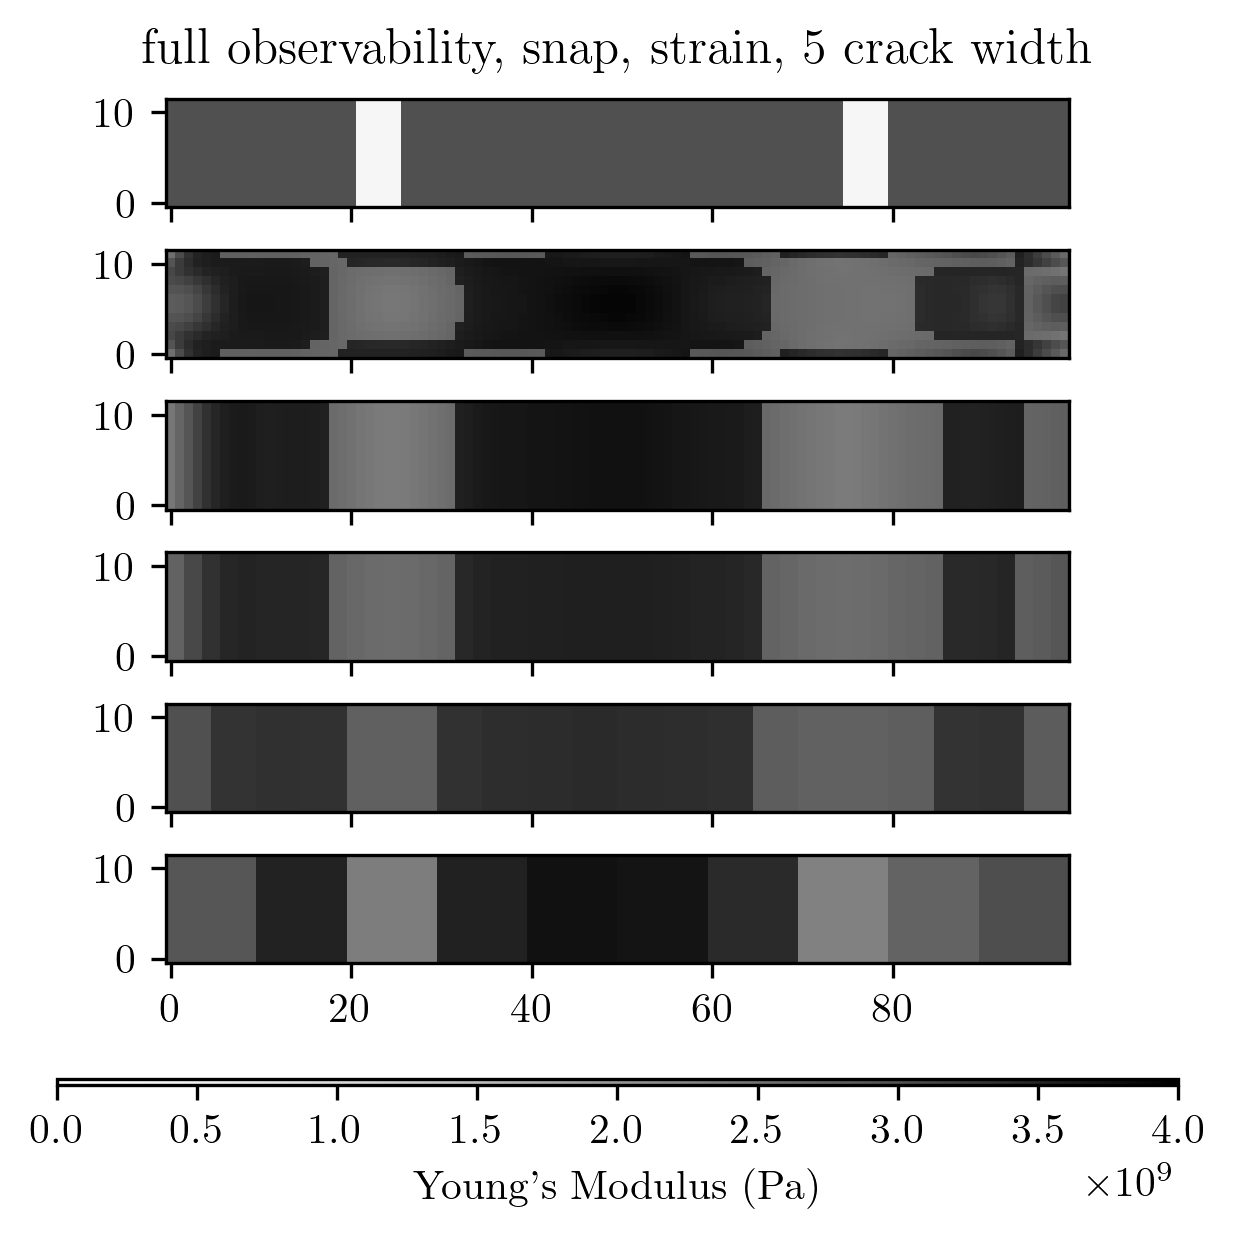

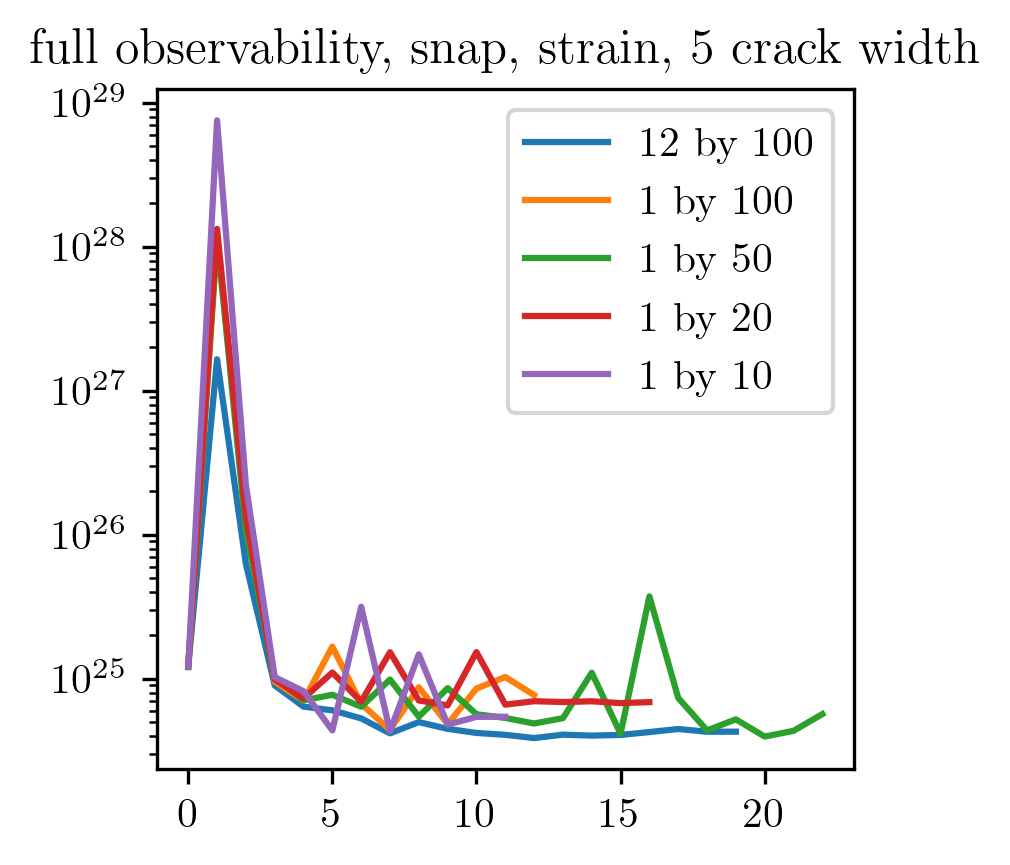

In [44]:
import einops, json, itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('text', usetex = True)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300
font = {'size'   : 20}

size = 2.000 # 2 m
span = 1.000 # 4.4 m
depth = 0.120 # 0.4 m
dim = 2
factor = 1/100
Nx = int(span / factor)
Ny = int(depth / factor)
n_particles = int(Nx * Ny)
grid_factor = 1
n_grid = 16*grid_factor

file = "E_1.npy"
result = np.load(file, allow_pickle=True)
E_1 = einops.rearrange(result, "(y x) -> x y", y=Ny).transpose()
file = "E_5.npy"
result = np.load(file, allow_pickle=True)
E_5 = einops.rearrange(result, "(y x) -> x y", y=Ny).transpose()

obs_choices = ["full"]
snapshots = ["hist", "snap"]
losstypes = [ "disp", "strain"]
n_blocks_xs = ["100", "50", "20", "10"]
n_blocks_ys = ["1"]

widths = ["1", "5"]

sequence = [
    "12 by 100",
    "1 by 100",
    "1 by 50",
    "1 by 20",
    "1 by 10"
]

combinations = list(itertools.product(obs_choices, snapshots, losstypes, widths))
for obs, snapshot, losstype, width in combinations:

    fig, axs = plt.subplots(6,1, sharex=True, sharey=True, figsize=(4,4), layout='constrained')
    plt.suptitle(f"{obs} observability, {snapshot}, {losstype}, {width} crack width")
    if width == "1":
        E_true = E_1
    else:
        E_true = E_5
    im = axs[0].imshow(E_true, origin='lower', cmap='Greys', vmin=0, vmax=4e9)
    filename = [
        f"results/r_{obs}_{losstype}_{snapshot}_100_12_{width}.json",
        f"results/r_{obs}_{losstype}_{snapshot}_100_1_{width}.json",
        f"results/r_{obs}_{losstype}_{snapshot}_50_1_{width}.json",
        f"results/r_{obs}_{losstype}_{snapshot}_20_1_{width}.json",
        f"results/r_{obs}_{losstype}_{snapshot}_10_1_{width}.json",
    ]
    losses = []
    for i, file in enumerate(filename):
        with open(file) as json_file:
            result = json.load(json_file)
        result_final = np.array(result["E_hist"])[-1]
        E = einops.rearrange(result_final, "(y x) -> x y", y=Ny).transpose()
        axs[1+i].imshow(E, origin='lower', cmap='Greys', vmin=0, vmax=4e9)
        losses.append(np.array(result["losses"]))
        print(len(result["losses"]))
    fig.colorbar(im, 
                ax=axs, 
                orientation = 'horizontal', 
                label='Young\'s Modulus (Pa)', 
                aspect=200)
    plt.show()
    plt.figure(figsize=(3,3))
    for i, loss in enumerate(losses):
        plt.title(f"{obs} observability, {snapshot}, {losstype}, {width} crack width")
        plt.plot(loss, label=sequence[i])
        plt.yscale('log')
        plt.legend()
    plt.show()

[3.53316768e+08 3.00000000e+09]
[1.e+08 3.e+09]
[2.9927728e+08 3.0000000e+09]
[1.02240288e+08 3.00000000e+09]


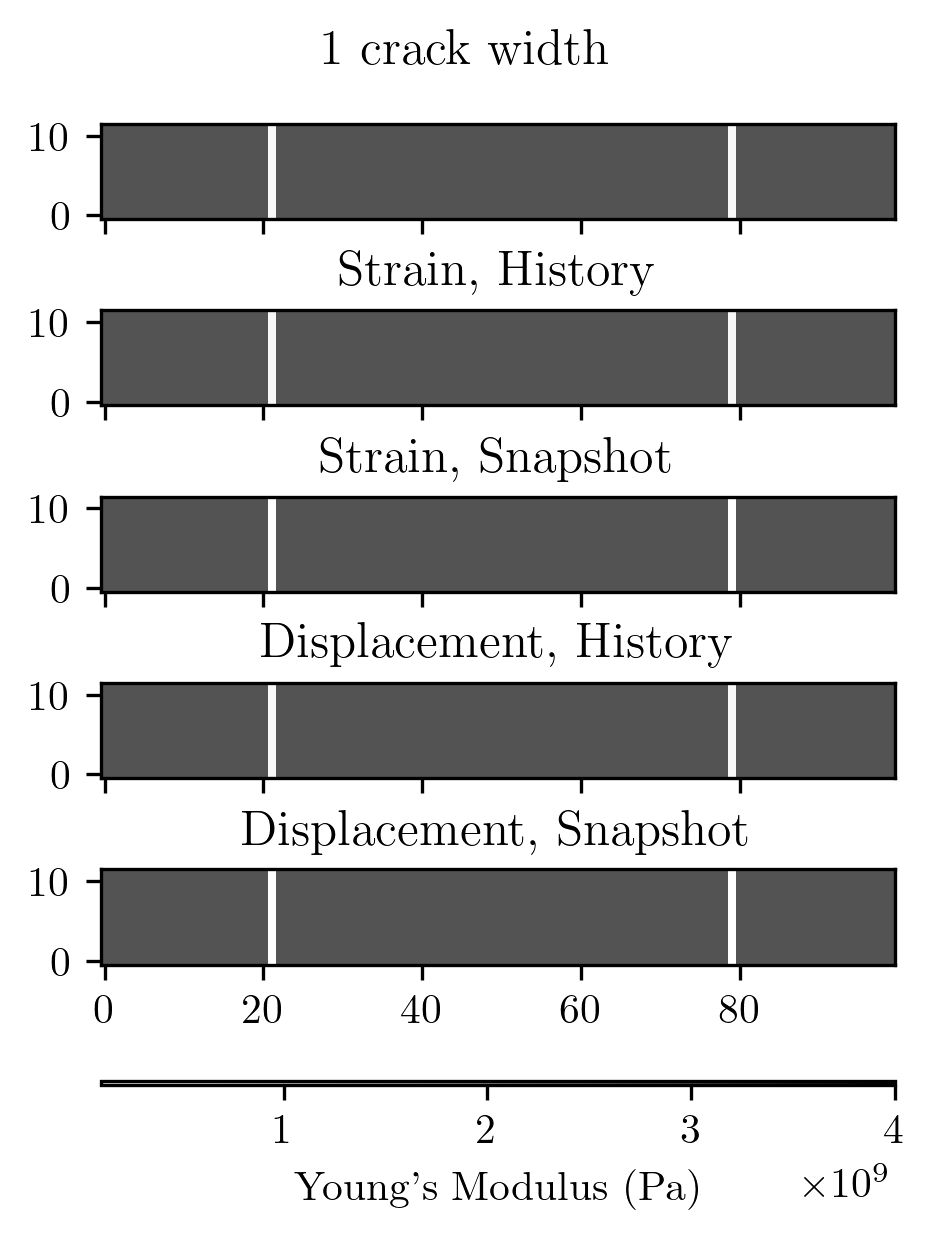

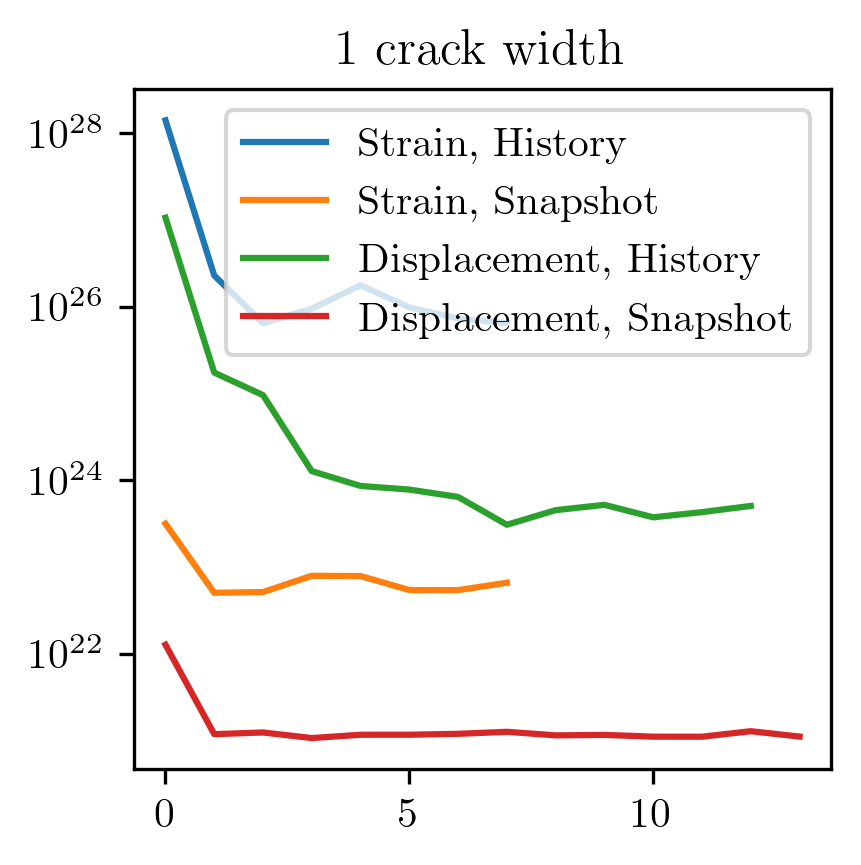

[3.33844704e+08 3.00000000e+09]
[6.3269728e+08 3.0000000e+09]
[3.00208576e+08 3.00000000e+09]
[3.03315712e+08 3.00000000e+09]


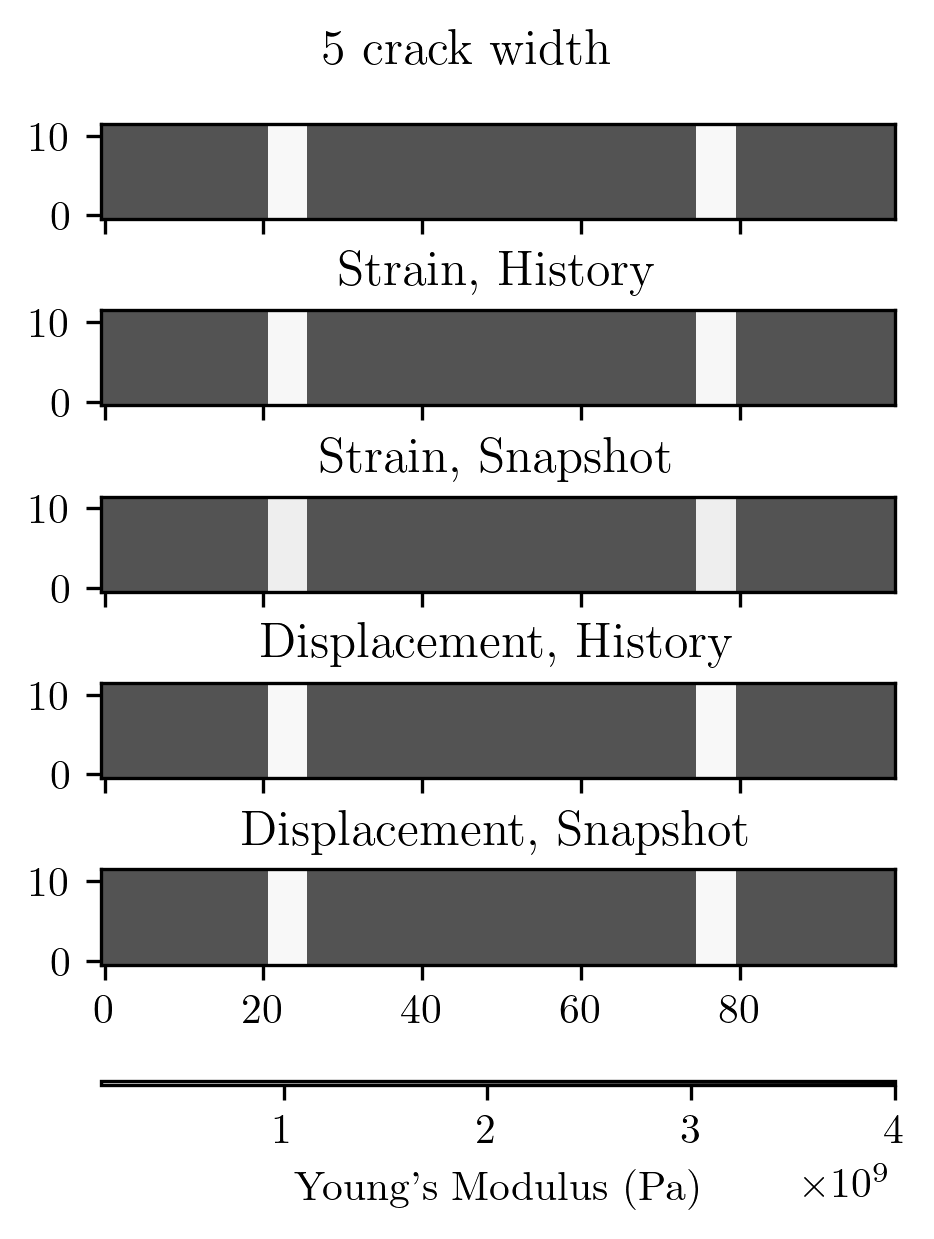

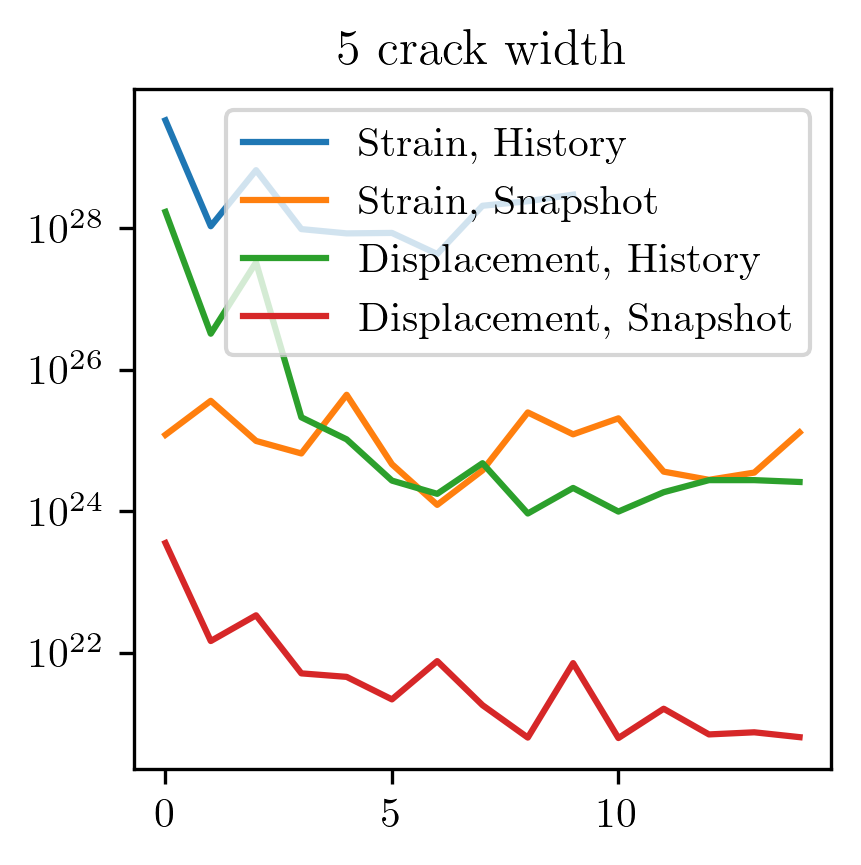

In [ ]:
import einops, json, itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('text', usetex = True)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300
font = {'size'   : 20}

size = 2.000 # 2 m
span = 1.000 # 4.4 m
depth = 0.120 # 0.4 m
dim = 2
factor = 1/100
Nx = int(span / factor)
Ny = int(depth / factor)
n_particles = int(Nx * Ny)
grid_factor = 1
n_grid = 16*grid_factor

file = "E_1.npy"
result = np.load(file, allow_pickle=True)
E_1 = einops.rearrange(result, "(y x) -> x y", y=Ny).transpose()
file = "E_5.npy"
result = np.load(file, allow_pickle=True)
E_5 = einops.rearrange(result, "(y x) -> x y", y=Ny).transpose()

obs_choices = ["full"]
snapshots = ["hist", "snap"]
losstypes = [ "disp", "strain"]
widths = ["1", "5"]

sequence = [
    "Strain, History",
    "Strain, Snapshot",
    "Displacement, History",
    "Displacement, Snapshot",
]
obs = obs_choices[0]
for width in widths:
    fig, axs = plt.subplots(5,1, sharex=True, sharey=True, figsize=(3,4), layout='constrained')
    plt.suptitle(f"{width} crack width")
    if width == "1":
        E_true = E_1
    else:
        E_true = E_5
    im = axs[0].imshow(E_true, origin='lower', cmap='Greys', vmin=1e8, vmax=4e9)
    filename = [
        f"results/r_{obs}_strain_hist_{width}_constrain.json",
        f"results/r_{obs}_strain_snap_{width}_constrain.json",
        f"results/r_{obs}_disp_hist_{width}_constrain.json",
        f"results/r_{obs}_disp_snap_{width}_constrain.json",
    ]
    losses = []
    final_E = []
    for i, file in enumerate(filename):
        with open(file) as json_file:
            result = json.load(json_file)
        result_final = np.array(result["E_hist"])[-1]
        E = einops.rearrange(result_final, "(y x) -> x y", y=Ny).transpose()
        axs[1+i].imshow(E, origin='lower', cmap='Greys', vmin=1e8, vmax=4e9)
        axs[1+i].set_title(sequence[i])
        losses.append(np.array(result["losses"]))
        Es = np.unique(E)
        print(Es)
    fig.colorbar(im, 
                ax=axs, 
                orientation = 'horizontal', 
                label='Young\'s Modulus (Pa)', 
                aspect=200)
    plt.show()
    plt.figure(figsize=(3,3))
    for i, loss in enumerate(losses):
        plt.title(f"{width} crack width")
        plt.plot(loss, label=sequence[i])
        plt.yscale('log')
        plt.legend()
    plt.show()

In [27]:
s_1 = np.load("s_1.npy", allow_pickle=True)

s_5 = np.load("s_5.npy", allow_pickle=True)

np.sum((s_1[-1] - s_5[-1])**2, axis=(0)).flatten()

array([1.8365457e-05, 2.2863186e-07, 2.2863186e-07, 1.9447034e-06],
      dtype=float32)

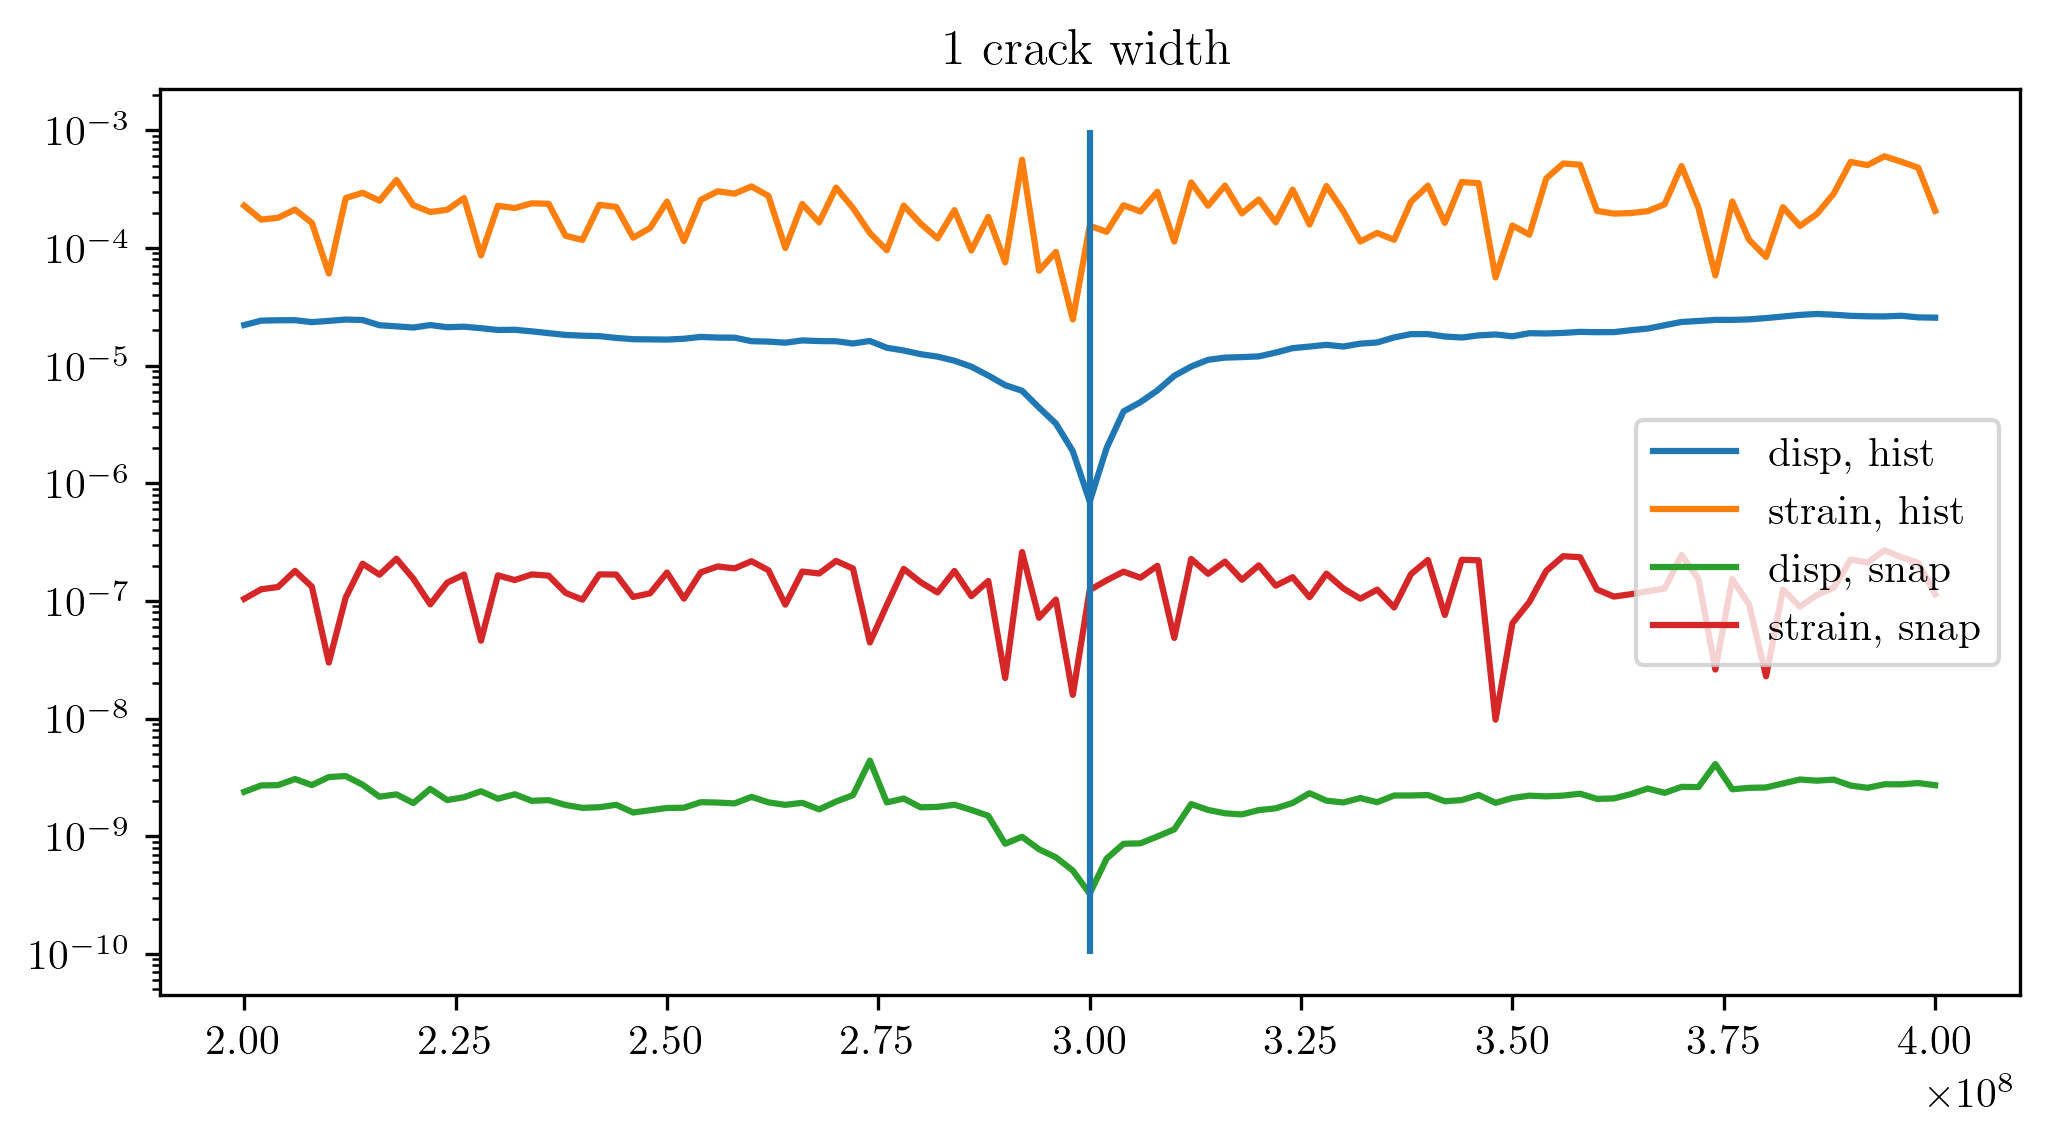

100%|██████████| 101/101 [02:47<00:00,  1.66s/it]


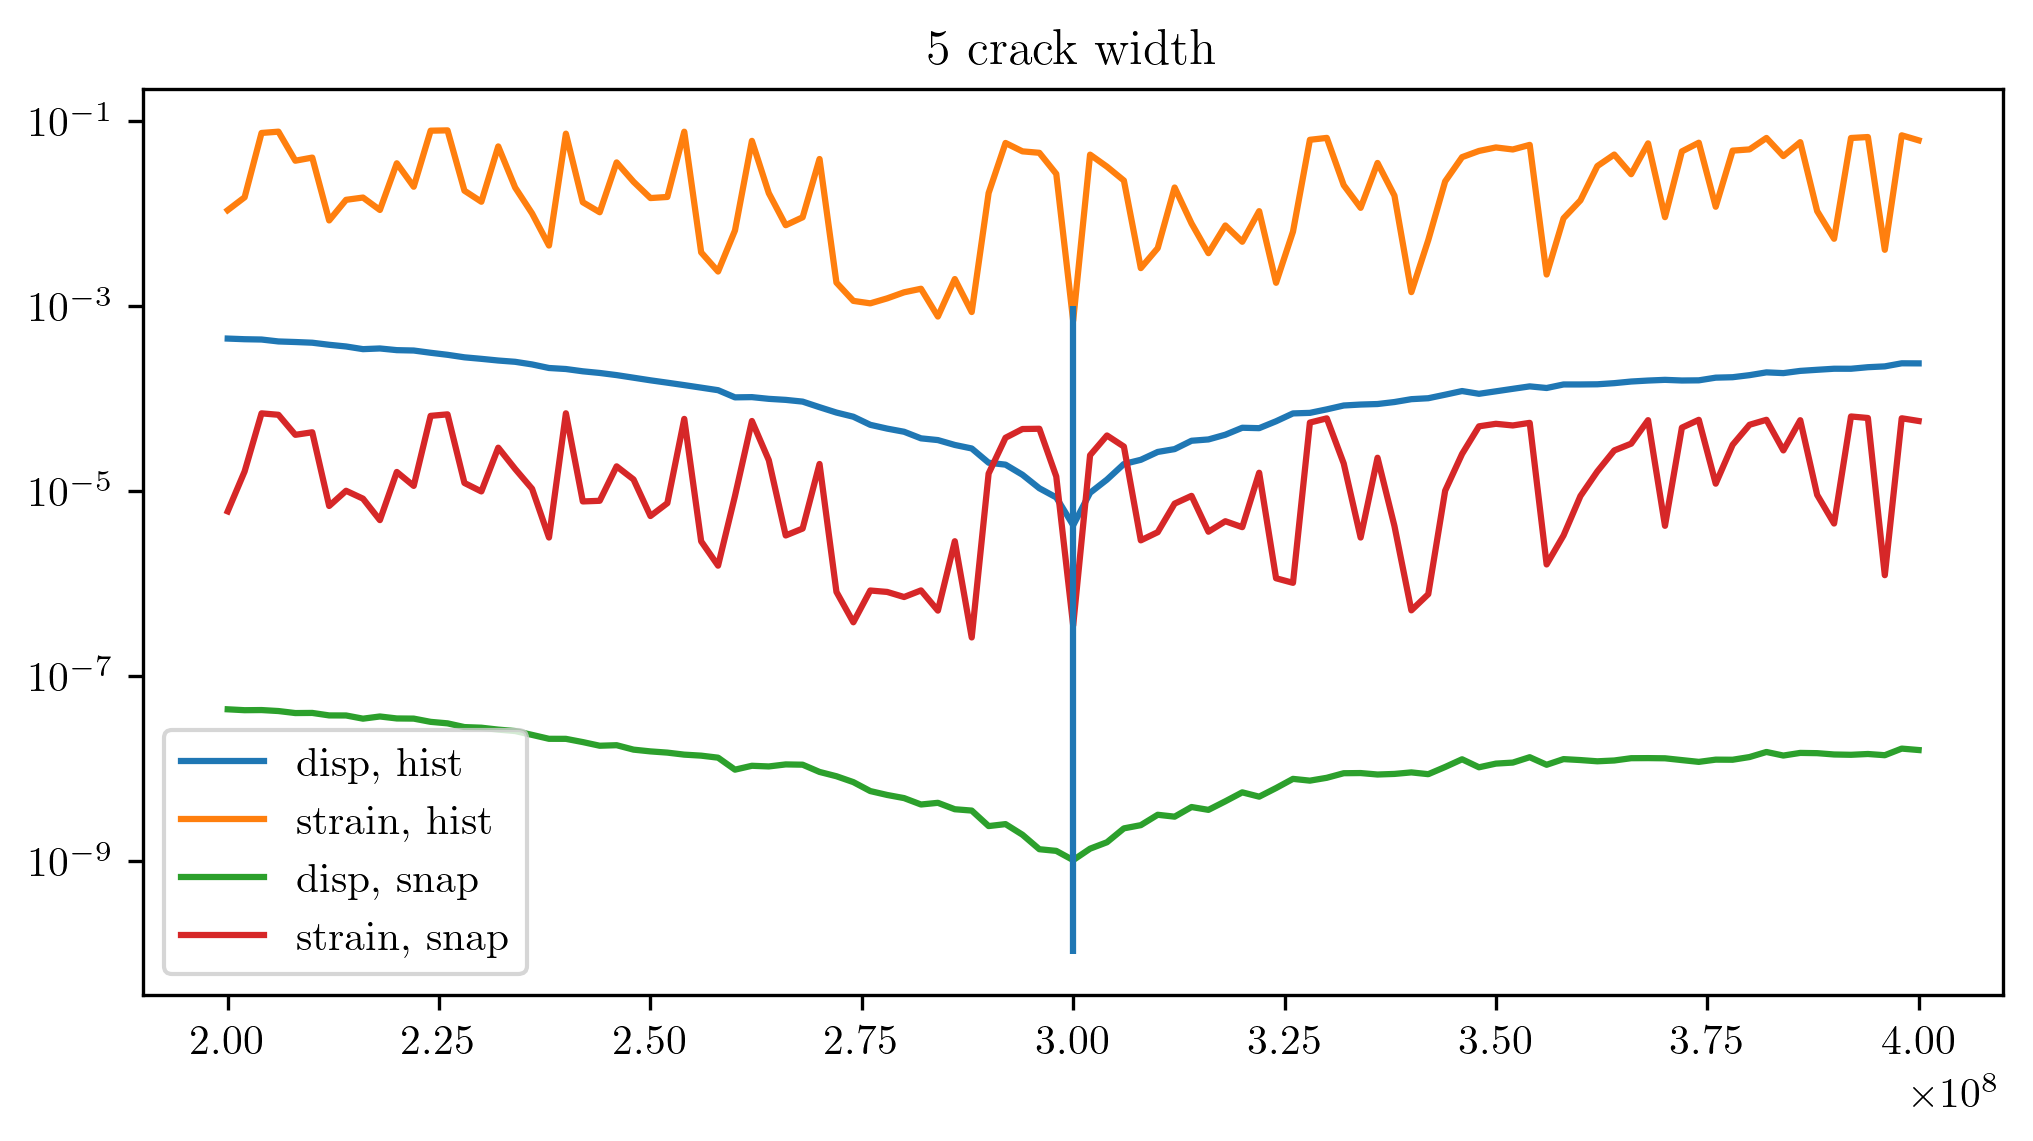

In [40]:
import einops, json, itertools, os, matplotlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

matplotlib.rc('text', usetex = True)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300
font = {'size'   : 20}

size = 2.000 # 2 m
span = 1.000 # 4.4 m
depth = 0.120 # 0.4 m
dim = 2
factor = 1/100
Nx = int(span / factor)
Ny = int(depth / factor)
n_particles = int(Nx * Ny)
grid_factor = 1
n_grid = 16*grid_factor

s_1 = np.load("s_1.npy", allow_pickle=True)
disp_1 = np.load("disp_1.npy", allow_pickle=True)
s_5 = np.load("s_5.npy", allow_pickle=True)
disp_5 = np.load("disp_5.npy", allow_pickle=True)

snapshots = ["hist", "snap"]
losstypes = [ "disp", "strain"]
widths = ["1", "5"]

init_Es = [str(int(i)) for i in np.linspace(2e8, 4e8, 101)]
combinations = list(itertools.product(snapshots, losstypes))

def compute_loss(result, losstype, snapshot, width):
    if width == "1":
        if losstype == "strain":
            target = s_1
            if snapshot == "hist":
                loss = np.sum(np.sum((target - result)**2, axis=(0,1)).flatten()[[0,1,3]])
            if snapshot == "snap":
                loss = np.sum(np.sum((target[-1] - result[-1])**2, axis=(0)).flatten()[[0,1,3]])
        if losstype == "disp":
            target = disp_1
            if snapshot == "hist":
                loss = np.sum(np.sum((target - result)**2, axis=(0,1)))
            if snapshot == "snap":
                loss = np.sum(np.sum((target[-1] - result[-1])**2, axis=(0)))
    if width == "5":
        if losstype == "strain":
            target = s_5
            if snapshot == "hist":
                loss = np.sum(np.sum((target - result)**2, axis=(0,1)).flatten()[[0,1,3]])
            if snapshot == "snap":
                loss = np.sum(np.sum((target[-1] - result[-1])**2, axis=(0)).flatten()[[0,1,3]])
        if losstype == "disp":
            target = disp_5
            if snapshot == "hist":
                loss = np.sum(np.sum((target - result)**2, axis=(0,1)))
            if snapshot == "snap":
                loss = np.sum(np.sum((target[-1] - result[-1])**2, axis=(0)))
    return loss

for width in widths:
    plt.figure(figsize=(8,4))
    plt.title(f"{width} crack width")
    
    for snapshot, losstype in combinations:
        losses = []
        if os.path.exists(f"losses_{losstype}_{snapshot}_{width}.npy"):
            losses = np.load(f"losses_{losstype}_{snapshot}_{width}.npy", allow_pickle=True)
        else:
            if losstype == "strain":
                prefix = "s"
            else:
                prefix = "disp"
            for init_E in tqdm(init_Es):
                result = np.load(f"results/{prefix}_{width}_{int(init_E)}.npy", allow_pickle=True)
                losses.append(compute_loss(result, losstype, snapshot, width))

            np.save(f"losses_{losstype}_{snapshot}_{width}.npy", np.array(losses))
        plt.plot(np.linspace(2e8, 4e8, 101), losses, label=f"{losstype}, {snapshot}")
    plt.vlines(3e8,1e-10,1e-3)
    plt.yscale('log')
    plt.legend()
    plt.show()

In [48]:
np.load("s_4_1.npy", allow_pickle=True).max()

0.0

13
13
17
14
18


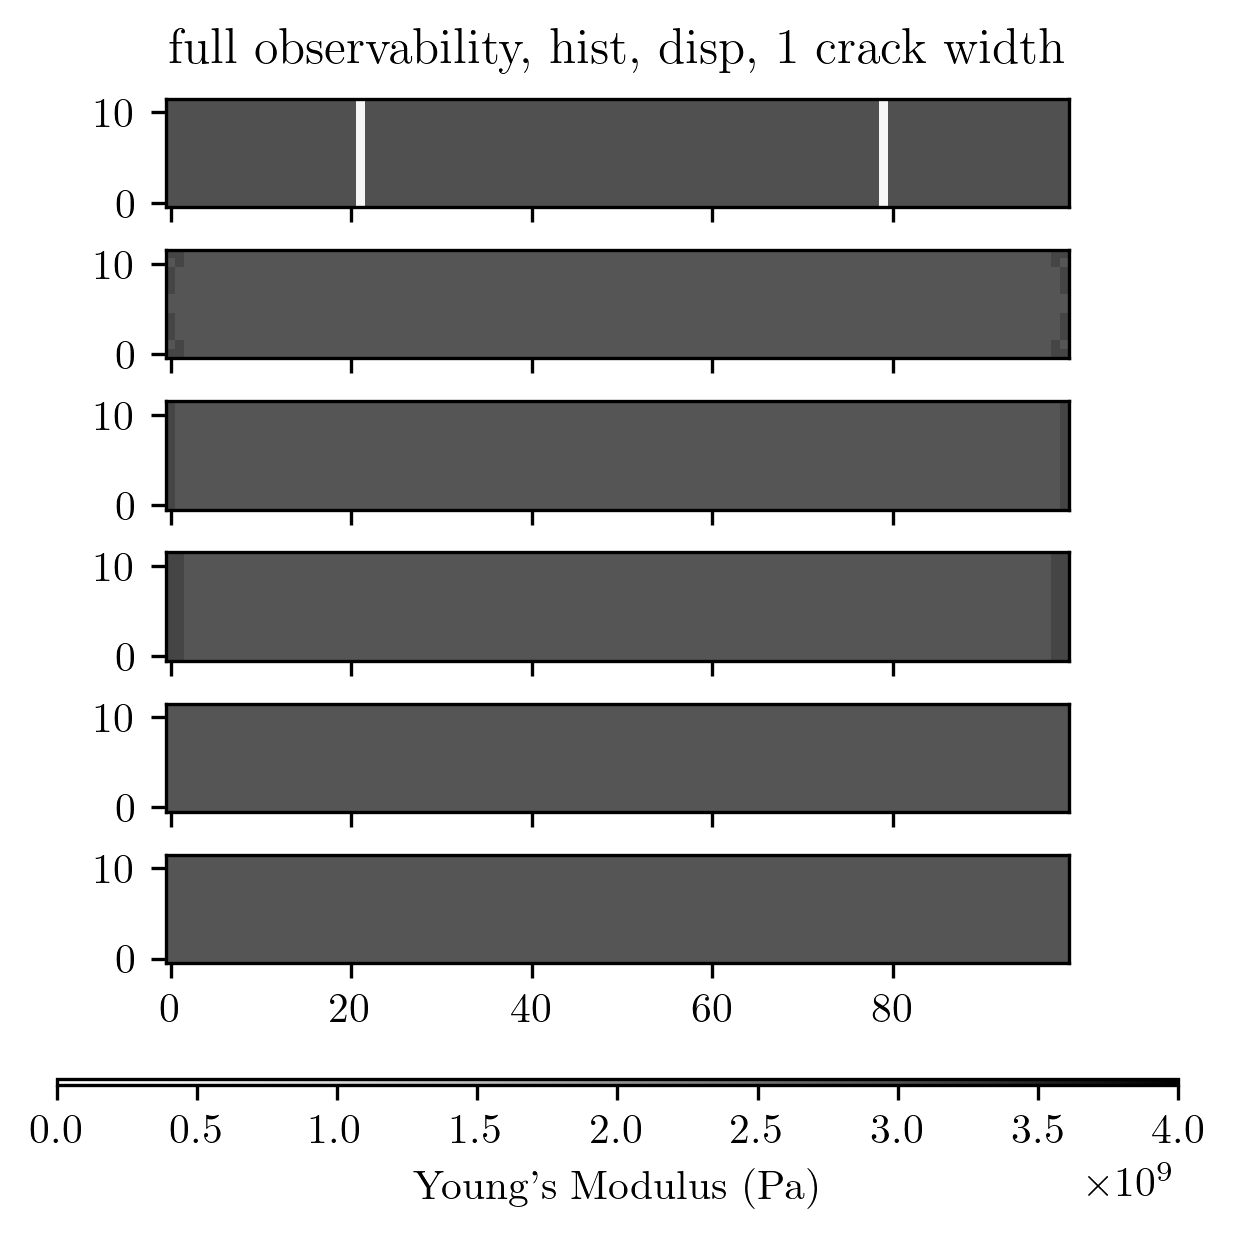

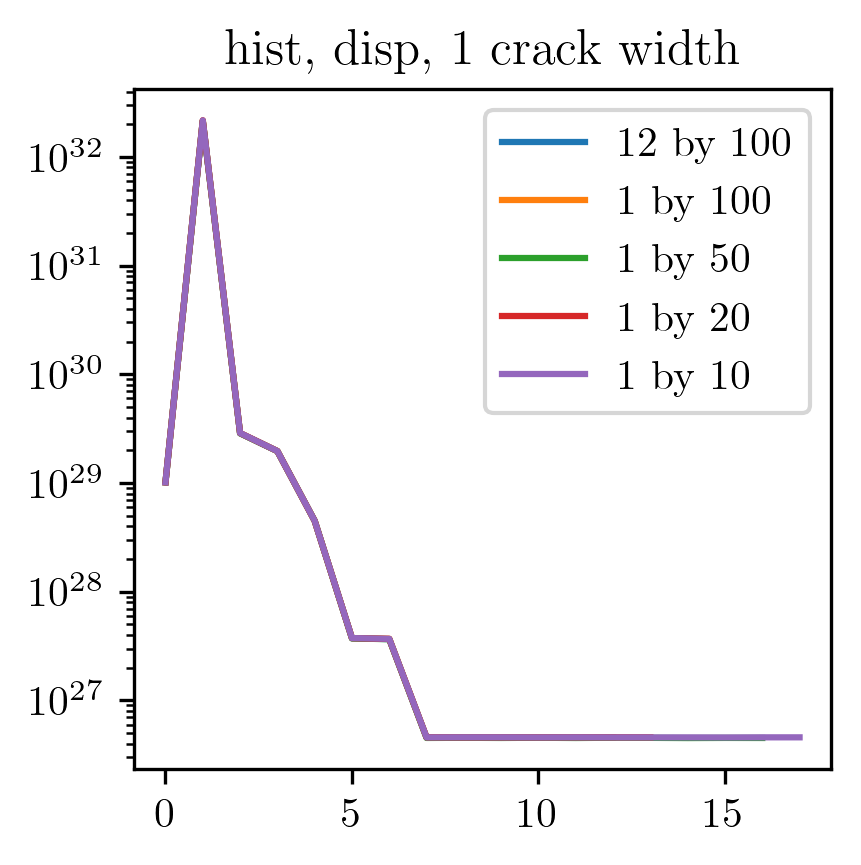

95
76
58
64
79


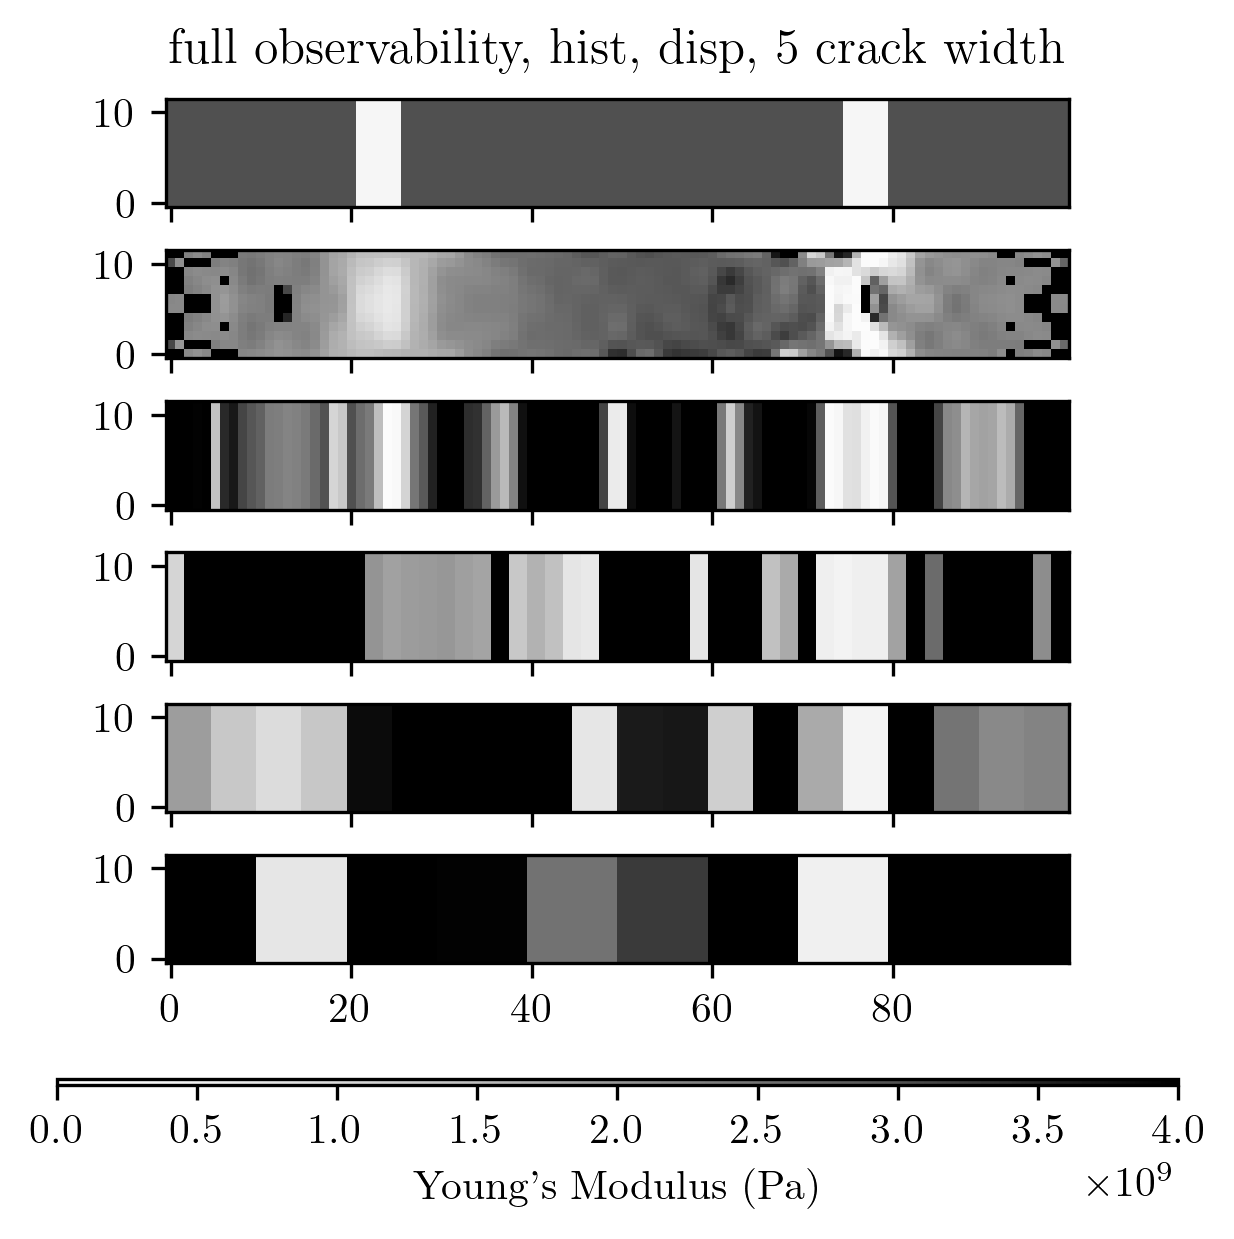

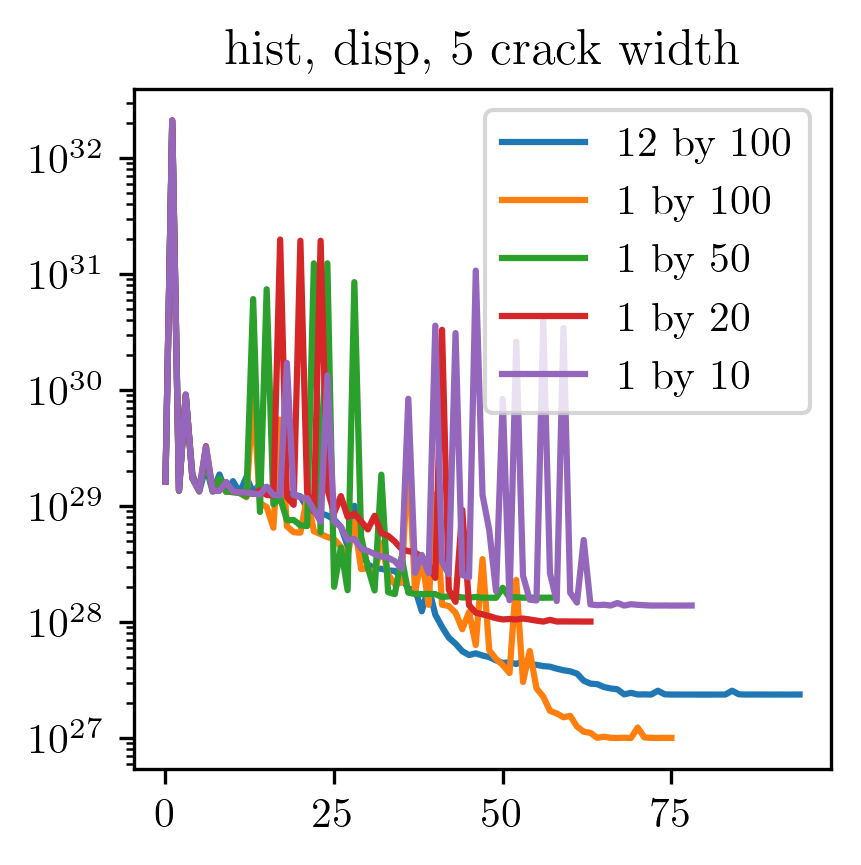

79
46
49
45
43


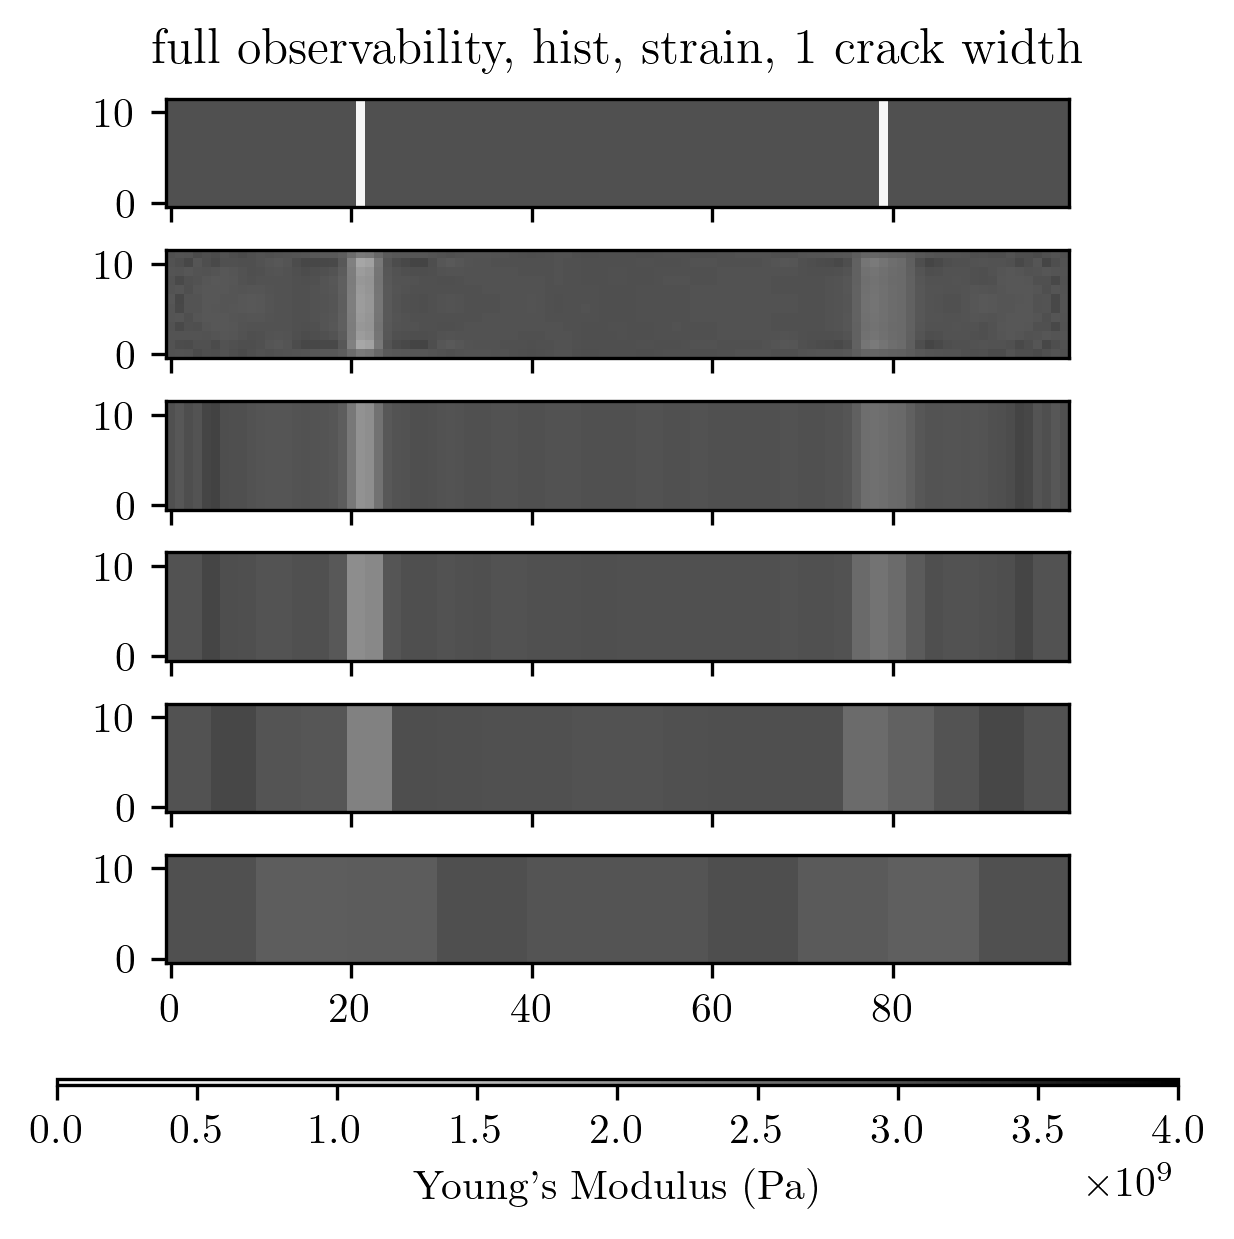

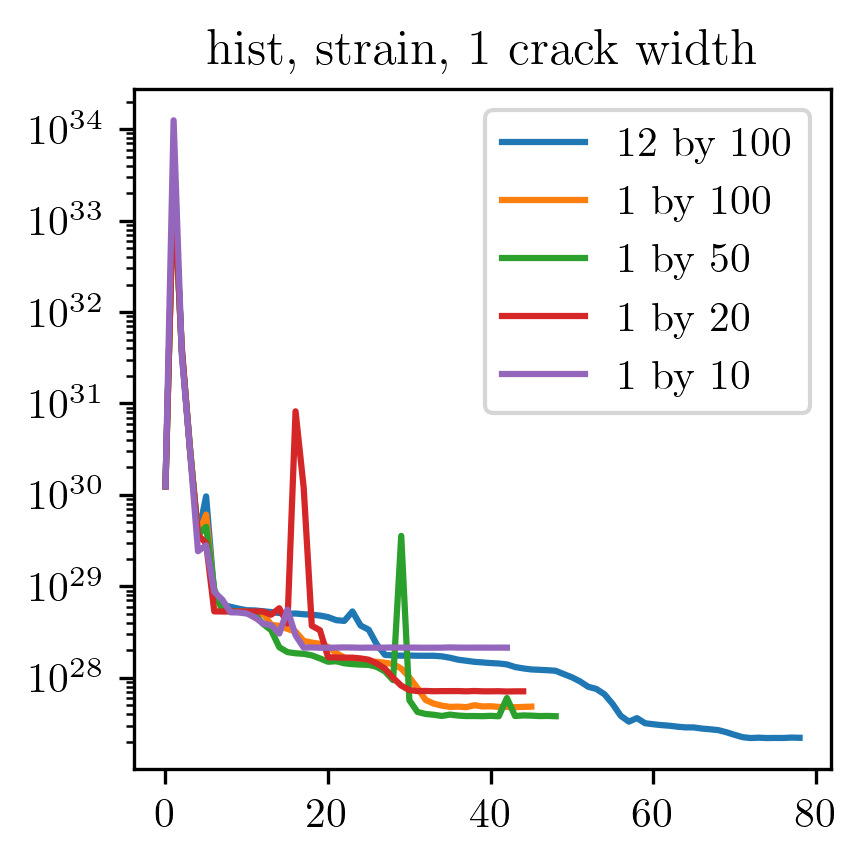

52
45
54
38
38


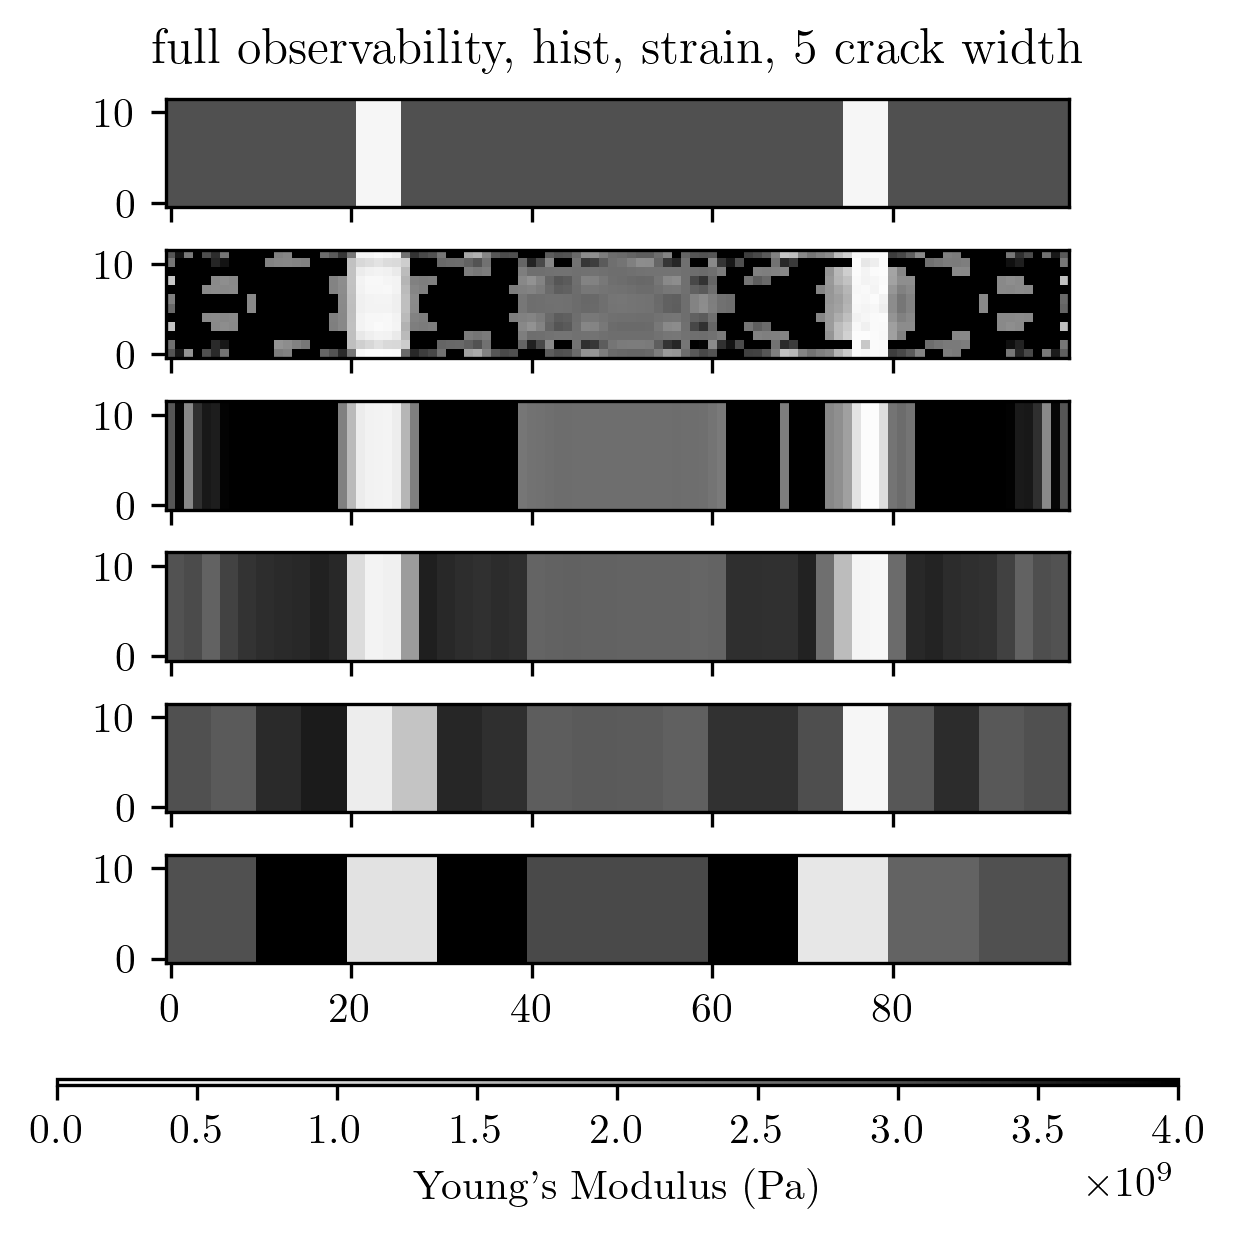

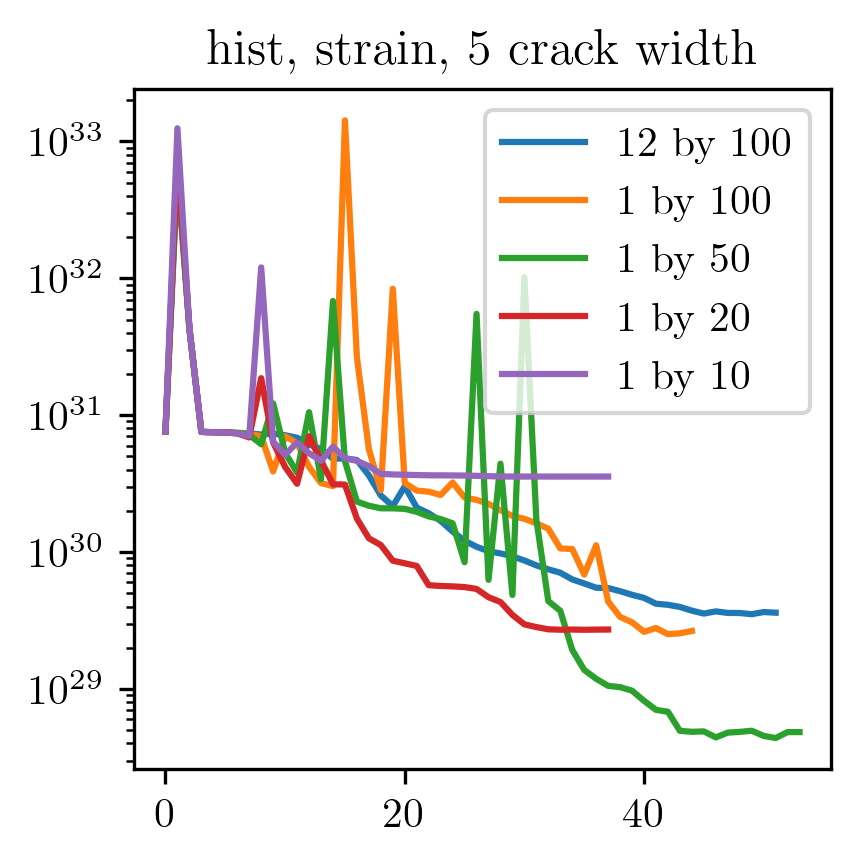

22
15
19
24
14


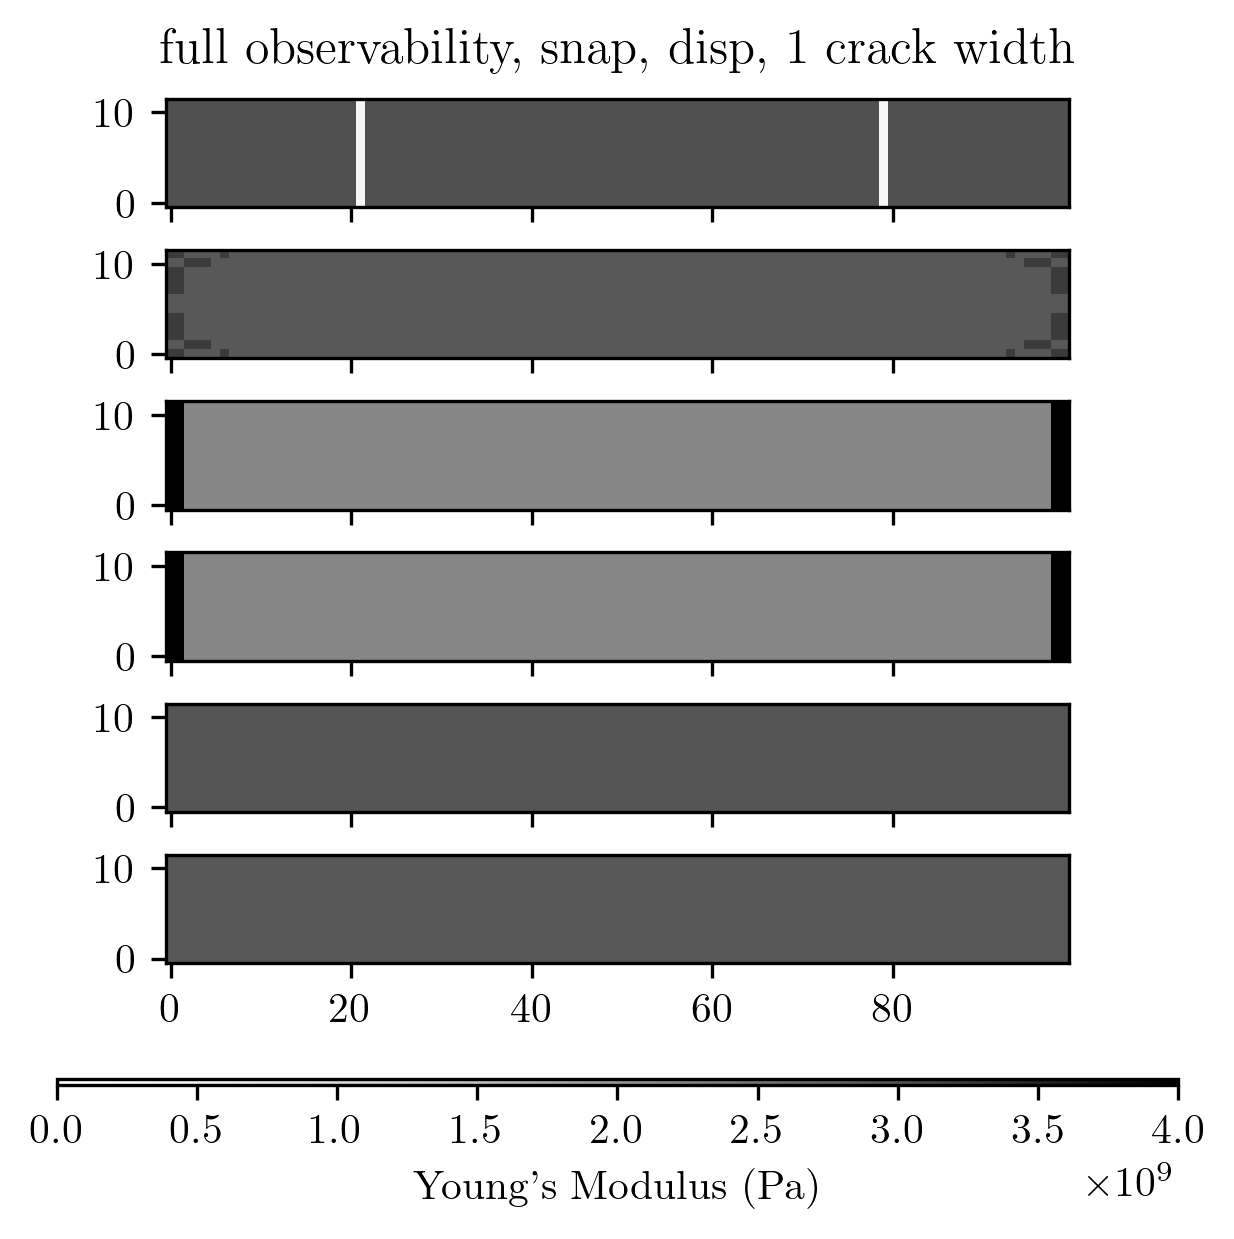

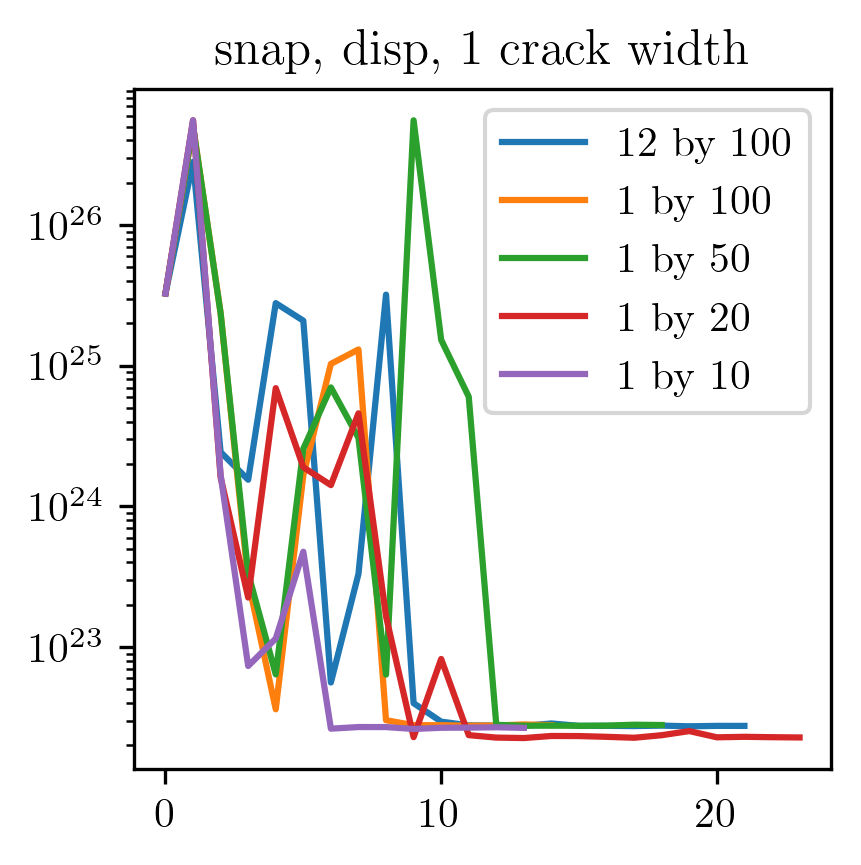

32
28
36
24
31


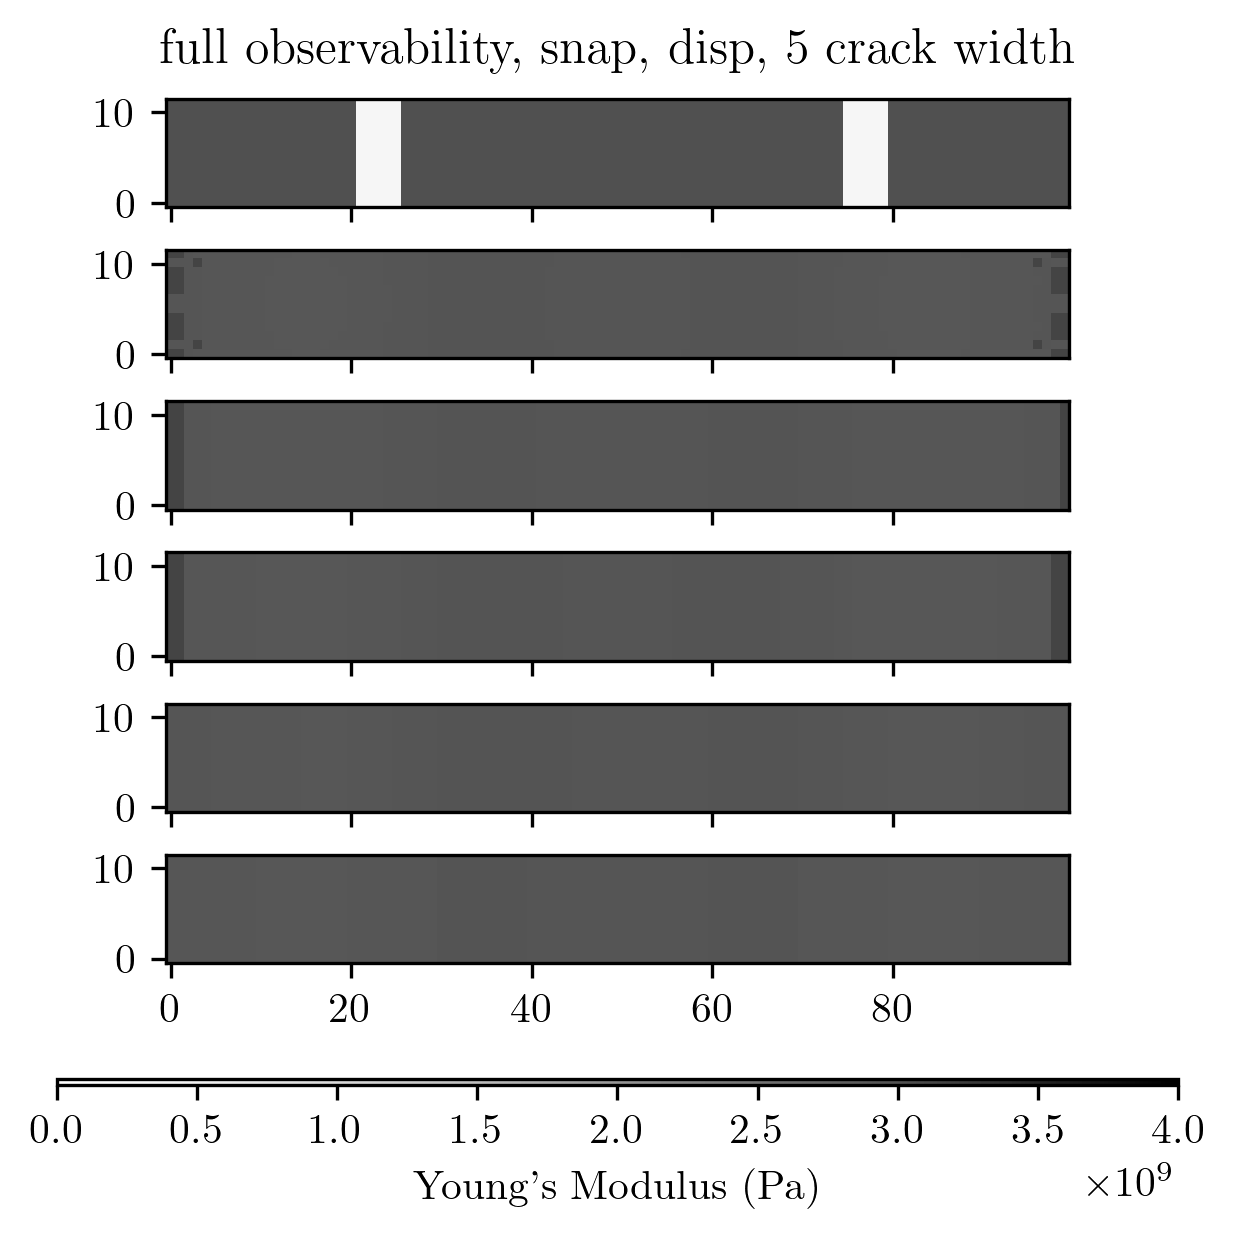

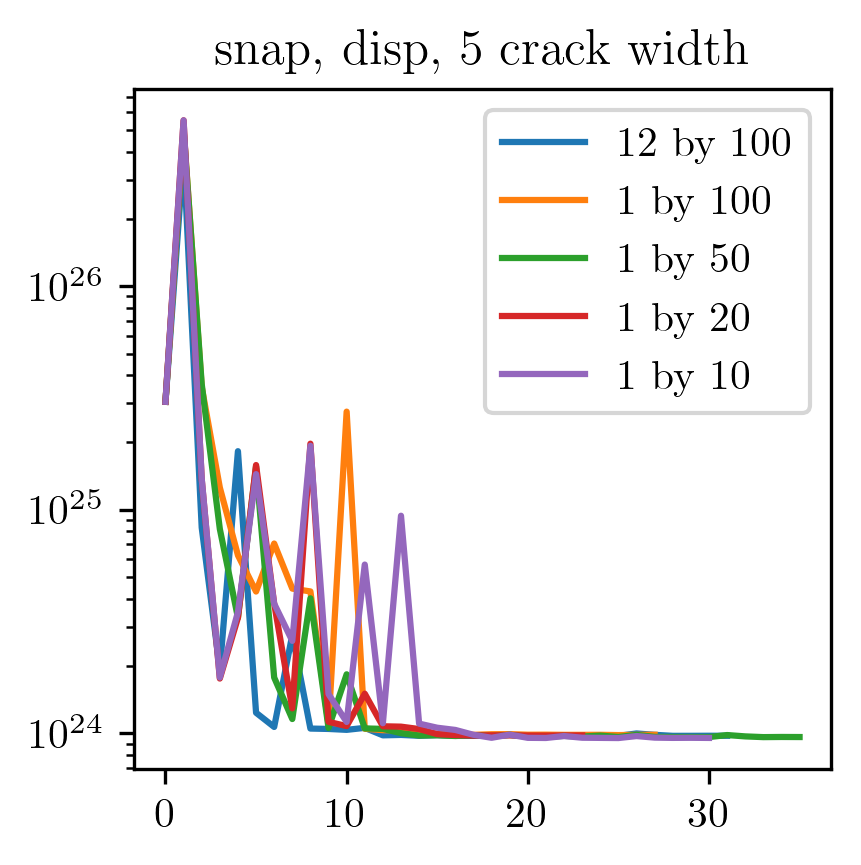

46
46
31
50
32


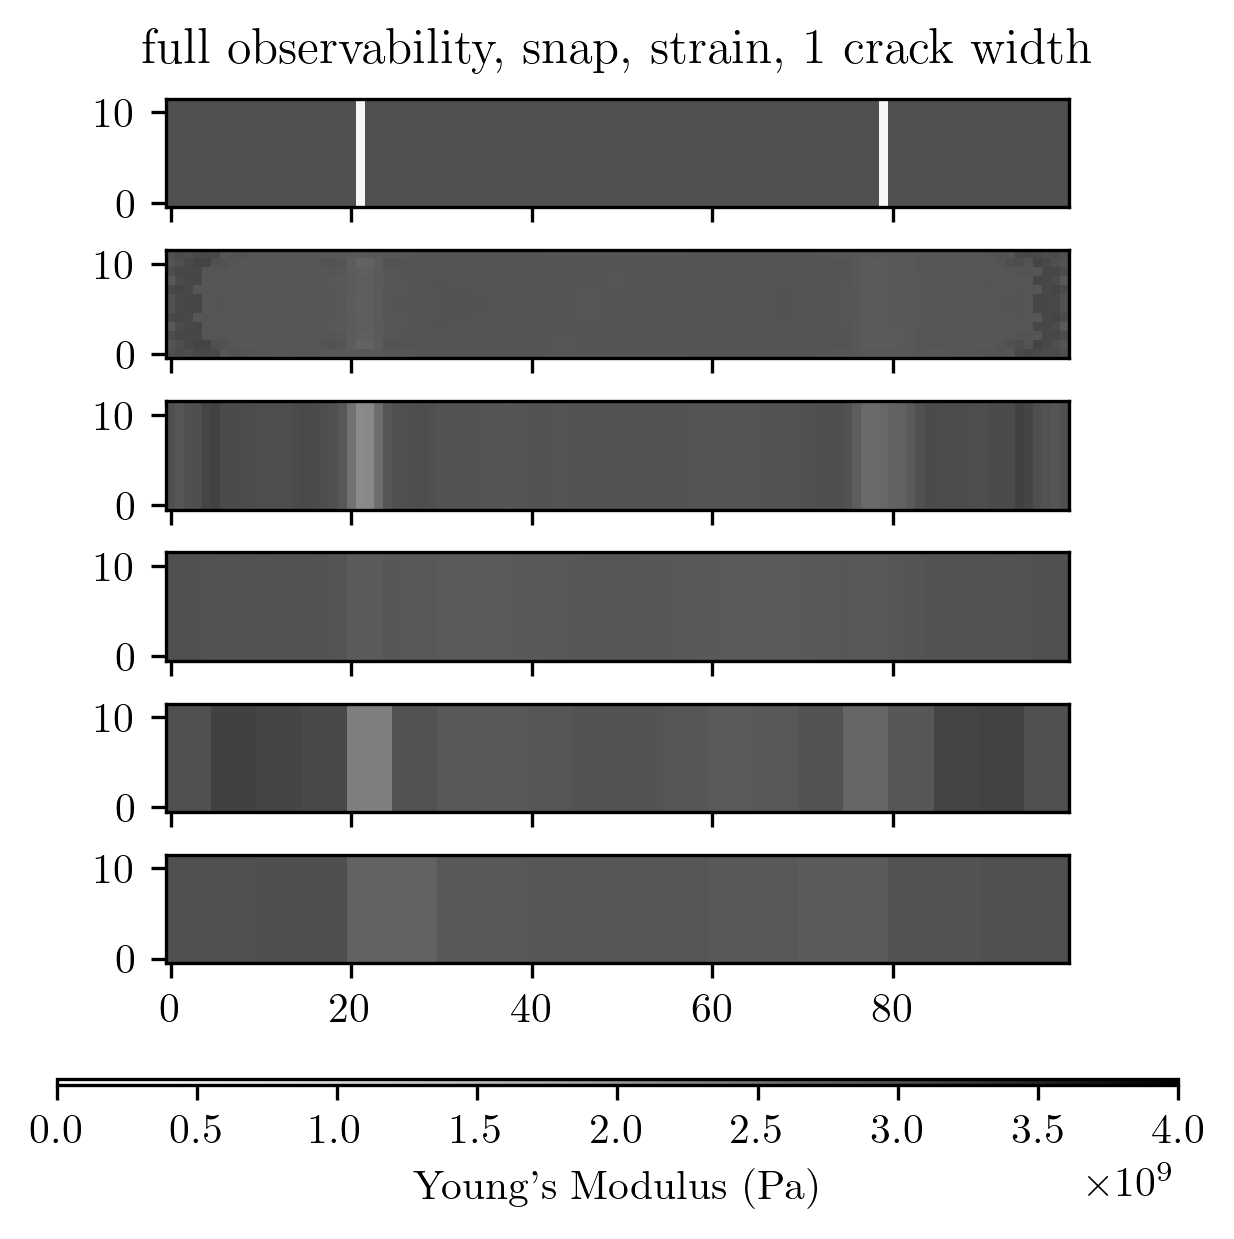

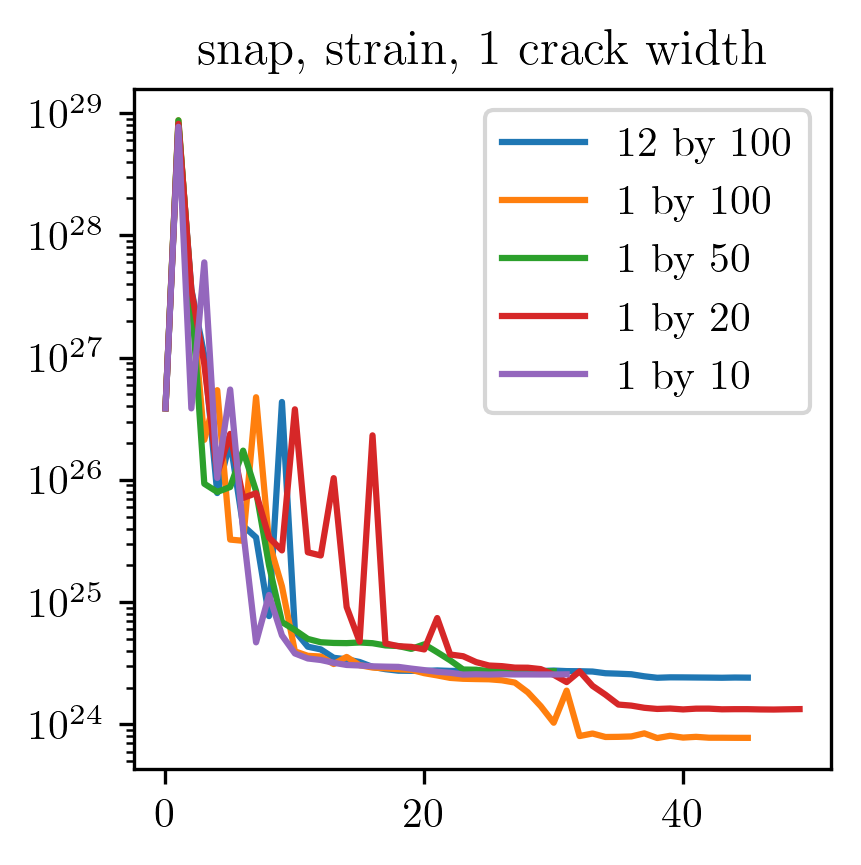

89
65
37
56
67


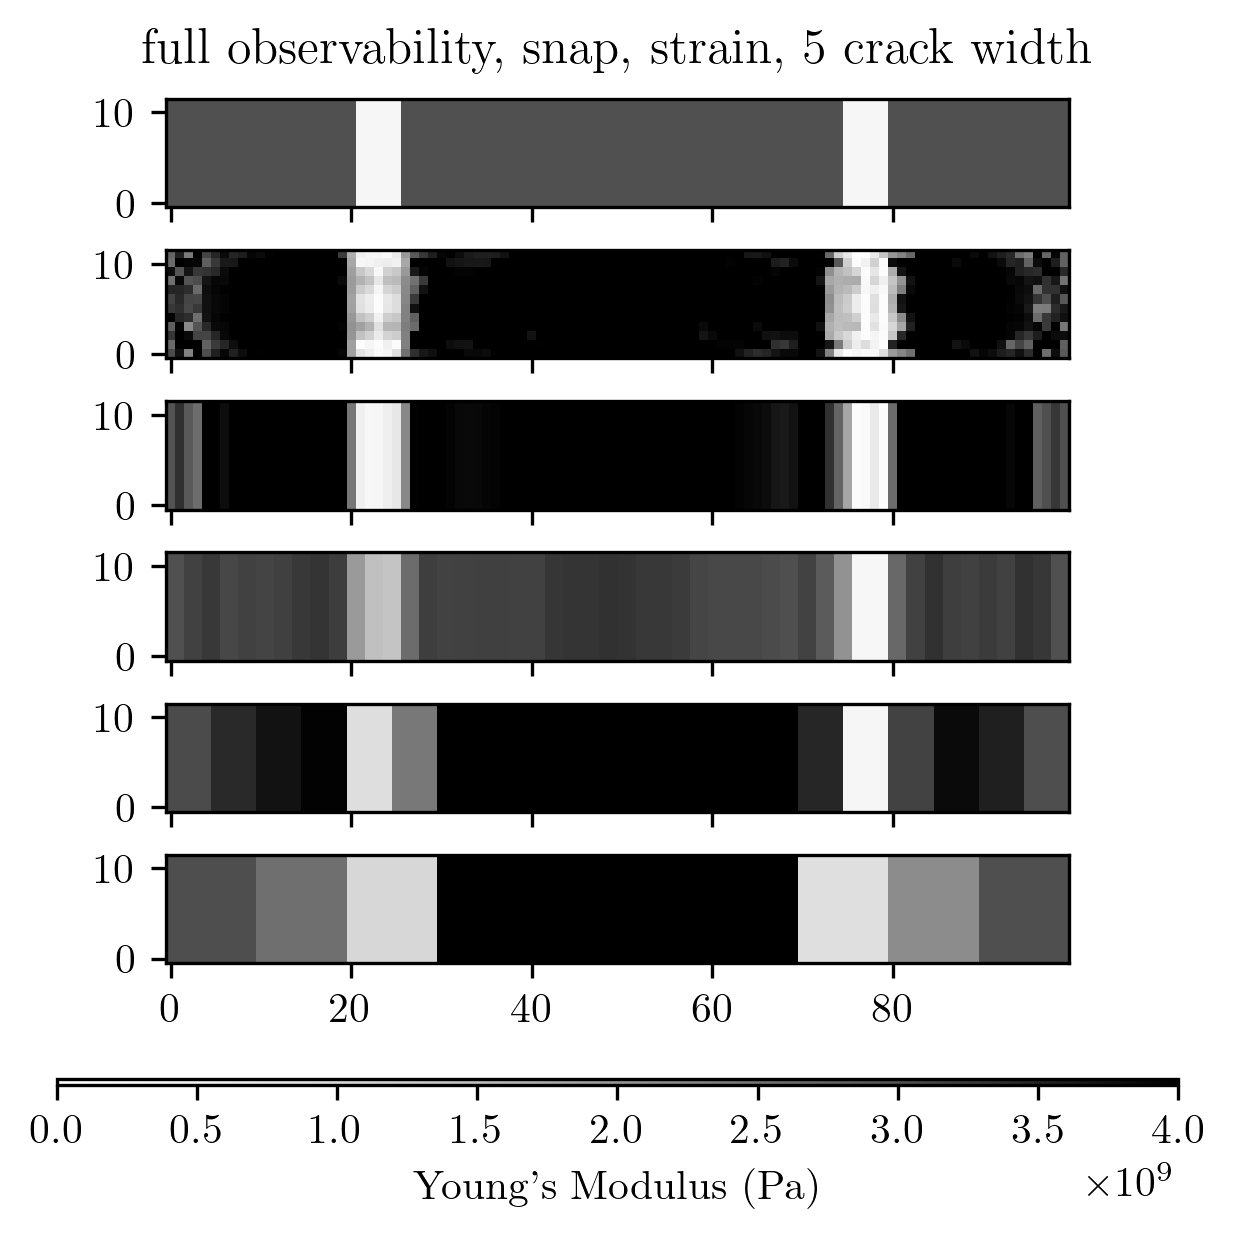

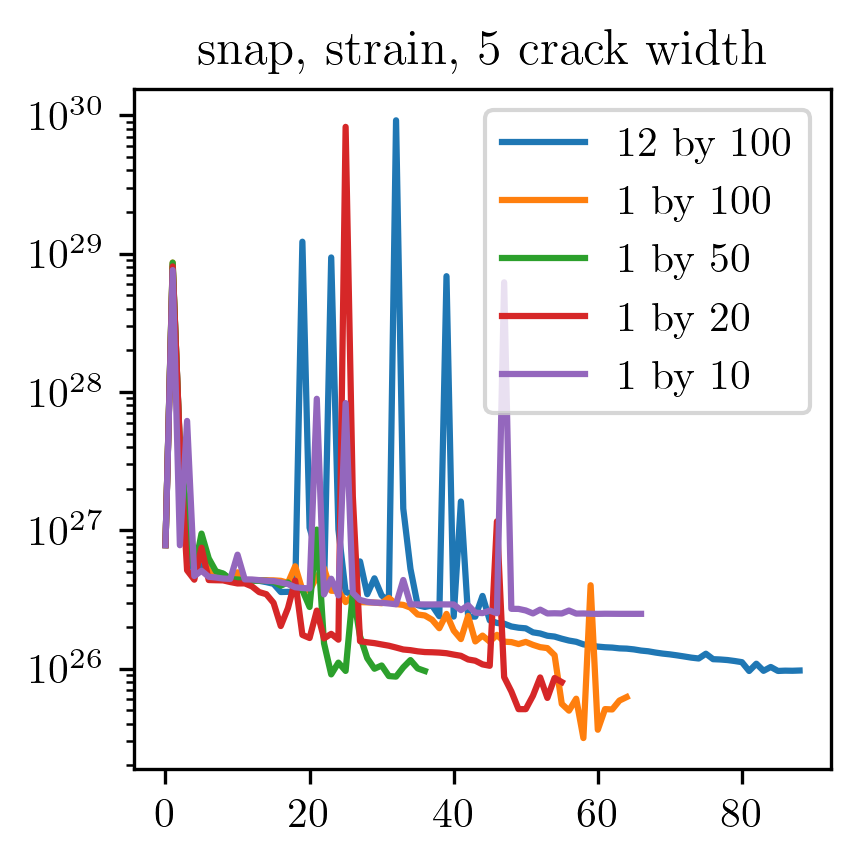

In [3]:
import einops, json, itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('text', usetex = True)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300
font = {'size'   : 20}

size = 2.000 # 2 m
span = 1.000 # 4.4 m
depth = 0.120 # 0.4 m
dim = 2
factor = 1/100
Nx = int(span / factor)
Ny = int(depth / factor)
n_particles = int(Nx * Ny)
grid_factor = 1
n_grid = 16*grid_factor

file = "E_1.npy"
result = np.load(file, allow_pickle=True)
E_1 = einops.rearrange(result, "(y x) -> x y", y=Ny).transpose()
file = "E_5.npy"
result = np.load(file, allow_pickle=True)
E_5 = einops.rearrange(result, "(y x) -> x y", y=Ny).transpose()

obs_choices = ["full"]
snapshots = ["hist", "snap"]
losstypes = [ "disp", "strain"]
n_blocks_xs = ["100", "50", "20", "10"]
n_blocks_ys = ["1"]

widths = ["1", "5"]

sequence = [
    "12 by 100",
    "1 by 100",
    "1 by 50",
    "1 by 20",
    "1 by 10"
]

combinations = list(itertools.product(obs_choices, snapshots, losstypes, widths))
for obs, snapshot, losstype, width in combinations:

    fig, axs = plt.subplots(6,1, sharex=True, sharey=True, figsize=(4,4), layout='constrained')
    plt.suptitle(f"{obs} observability, {snapshot}, {losstype}, {width} crack width")
    if width == "1":
        E_true = E_1
    else:
        E_true = E_5
    im = axs[0].imshow(E_true, origin='lower', cmap='Greys', vmin=0, vmax=4e9)
    filename = [
        f"results/r_4_{obs}_{losstype}_{snapshot}_100_12_{width}.json",
        f"results/r_4_{obs}_{losstype}_{snapshot}_100_1_{width}.json",
        f"results/r_4_{obs}_{losstype}_{snapshot}_50_1_{width}.json",
        f"results/r_4_{obs}_{losstype}_{snapshot}_20_1_{width}.json",
        f"results/r_4_{obs}_{losstype}_{snapshot}_10_1_{width}.json",
    ]
    losses = []
    for i, file in enumerate(filename):
        with open(file) as json_file:
            result = json.load(json_file)
        result_final = np.array(result["E_hist"])[-1]
        E = einops.rearrange(result_final, "(y x) -> x y", y=Ny).transpose()
        axs[1+i].imshow(E, origin='lower', cmap='Greys', vmin=0, vmax=4e9)
        losses.append(np.array(result["losses"]))
        print(len(result["losses"]))
    fig.colorbar(im, 
                ax=axs, 
                orientation = 'horizontal', 
                label='Young\'s Modulus (Pa)', 
                aspect=200)
    plt.show()
    plt.figure(figsize=(3,3))
    for i, loss in enumerate(losses):
        plt.title(f"{snapshot}, {losstype}, {width} crack width")
        plt.plot(loss, label=sequence[i])
        plt.yscale('log')
        plt.legend()
    plt.show()